# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

## Описание проекта 

### Описание задачи:

* Чтобы не терпеть убытки от неожиданной отмены заказов, требуется разработать систему, которая предсказывает отказ от брони.

* По результатам предсказания модели, клиентам, которых положительно определит модель, будет предложенно внесение депозита, равное 80% от стоимости номера на одни сутки и затрат на разовубю уборку.

### Общая информация:

Прибыль:
* Разница между стоимостью номера за все ночи и затрата на обслуживание, как при подготовке номера, так и проживание постояльца.


Убыток в случае отмены:
* Стоимость одной ночи и одной уборки.

Сезонная ценовая политика в % надбавочной стоимости на номер:
* Лето - 40%
* Осень/Весна - 20%
* Зима - 0%

Стоимость номеров отеля:
* категория A: за ночь — 1 000, разовое обслуживание — 400;
* категория B: за ночь — 800, разовое обслуживание — 350; 
* категория C: за ночь — 600, разовое обслуживание — 350;
* категория D: за ночь — 550, разовое обслуживание — 150;
* категория E: за ночь — 500, разовое обслуживание — 150;
* категория F: за ночь — 450, разовое обслуживание — 150;
* категория G: за ночь — 350, разовое обслуживание — 150.

### Описание данных:

* id — номер записи;
* adults — количество взрослых постояльцев;
* arrival_date_year — год заезда;
* arrival_date_month — месяц заезда;
* arrival_date_week_number — неделя заезда;
* arrival_date_day_of_month — день заезда;
* babies — количество младенцев;
* booking_changes — количество изменений параметров заказа;
* children — количество детей от 3 до 14 лет;
* country — гражданство постояльца;
* customer_type — тип заказчика:
 1. Contract — договор с юридическим лицом;
 2. Group — групповой заезд;
 3. Transient — не связано с договором или групповым заездом;
 4. Transient-party — не связано с договором или групповым заездом, но связано с бронированием типа Transient.
* days_in_waiting_list — сколько дней заказ ожидал подтверждения;
* distribution_channel — канал дистрибуции заказа;
* is_canceled — отмена заказа;
* is_repeated_guest — признак того, что гость бронирует номер второй раз;
* lead_time — количество дней между датой бронирования и датой прибытия;
* meal — опции заказа:
 1. SC — нет дополнительных опций;
 2. BB — включён завтрак;
 3. HB — включён завтрак и обед;
 4. FB — включён завтрак, обед и ужин.
* previous_bookings_not_canceled — количество подтверждённых заказов у клиента;
* previous_cancellations — количество отменённых заказов у клиента;
* required_car_parking_spaces — необходимость места для автомобиля;
* reserved_room_type — тип забронированной комнаты;
* stays_in_weekend_nights — количество ночей в выходные дни;
* stays_in_week_nights — количество ночей в будние дни;
* total_nights — общее количество ночей;
* total_of_special_requests — количество специальных отметок.

##  Импорт и первичный просмотр

### Import

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import OrdinalEncoder 

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils import shuffle


from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_curve , roc_auc_score, confusion_matrix

pd.options.display.float_format = '{:,.2f}'.format

In [2]:
data = pd.read_csv('/datasets/hotel_train.csv')
data_test = pd.read_csv('/datasets/hotel_test.csv')

### Data train


In [3]:
def inform(data):
    display(data.head())
    display(data.info())
    display(data.describe())
    print('duplicated:', data.duplicated().sum())
    print('Nan:','\n', data.isna().sum())

In [4]:
inform(data)

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.00,2015,July,27,1,0,1,1.00,...,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.00,2015,July,27,1,0,2,2.00,...,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.00,2015,July,27,1,0,2,2.00,...,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.00,2015,July,27,1,0,2,2.00,...,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.00,2015,July,27,1,0,3,2.00,...,0,0,0,A,0,0,Transient,0,1,3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

None

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,"65,229.00","65,229.00","65,229.00","65,229.00","65,229.00","65,229.00","65,229.00","65,229.00","65,229.00","65,229.00","65,229.00","65,229.00","65,229.00","65,229.00","65,229.00","65,229.00","65,229.00","65,229.00","65,229.00"
mean,"43,544.07",0.37,96.34,"2,015.72",31.34,15.85,0.83,2.22,1.84,0.07,0.01,0.03,0.13,0.11,0.19,3.33,0.06,0.51,3.05
std,"25,614.86",0.48,96.13,0.45,13.46,8.75,0.85,1.35,0.48,0.33,0.10,0.16,0.97,1.33,0.59,18.24,0.23,0.75,1.74
min,0.00,0.00,0.00,"2,015.00",1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
25%,"19,108.00",0.00,17.00,"2,015.00",21.00,8.00,0.00,1.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00
50%,"40,554.00",0.00,64.00,"2,016.00",34.00,16.00,1.00,2.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.00
75%,"67,414.00",1.00,151.00,"2,016.00",42.00,23.00,2.00,3.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,4.00
max,"84,121.00",1.00,374.00,"2,016.00",53.00,31.00,4.00,6.00,4.00,3.00,10.00,1.00,26.00,58.00,17.00,259.00,3.00,5.00,10.00


duplicated: 0
Nan: 
 id                                0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
booking_changes                   0
days_in_waiting_list              0
customer_type                     0
required_car_parking_spaces       0
total_of_special_requests         0
total_nights                      0
dtype: int64


### Data test

In [5]:
inform(data_test)

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.00,2017,January,1,1,1,0,2.00,...,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.00,2017,January,1,1,2,2,2.00,...,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.00,2017,January,1,1,2,2,2.00,...,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71.00,2017,January,1,1,2,2,1.00,...,0,0,0,A,0,0,Transient,0,1,4
4,6090,1,172.00,2017,January,1,1,2,5,2.00,...,0,0,0,A,0,0,Transient,0,0,7


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal                            

None

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,"32,412.00","32,412.00","32,412.00","32,412.00","32,412.00","32,412.00","32,412.00","32,412.00","32,412.00","32,412.00","32,412.00","32,412.00","32,412.00","32,412.00","32,412.00","32,412.00","32,412.00","32,412.00","32,412.00"
mean,"60,131.51",0.39,97.59,"2,017.00",17.80,15.66,0.87,2.34,1.86,0.08,0.01,0.03,0.01,0.17,0.22,0.26,0.05,0.66,3.21
std,"29,953.59",0.49,86.51,0.00,9.18,8.77,0.85,1.38,0.49,0.34,0.08,0.17,0.18,1.88,0.64,4.73,0.22,0.83,1.74
min,"6,086.00",0.00,0.00,"2,017.00",1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
25%,"45,291.75",0.00,23.00,"2,017.00",10.00,8.00,0.00,1.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00
50%,"53,394.50",0.00,76.00,"2,017.00",18.00,15.50,1.00,2.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.00
75%,"89,800.25",1.00,155.00,"2,017.00",25.00,23.00,2.00,3.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,4.00
max,"97,903.00",1.00,373.00,"2,017.00",35.00,31.00,4.00,6.00,4.00,3.00,2.00,1.00,6.00,72.00,18.00,223.00,8.00,5.00,10.00


duplicated: 0
Nan: 
 id                                0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
booking_changes                   0
days_in_waiting_list              0
customer_type                     0
required_car_parking_spaces       0
total_of_special_requests         0
total_nights                      0
dtype: int64


## Предобработка и просмотр каждого столбца

### Матрица корреляции

<AxesSubplot:>

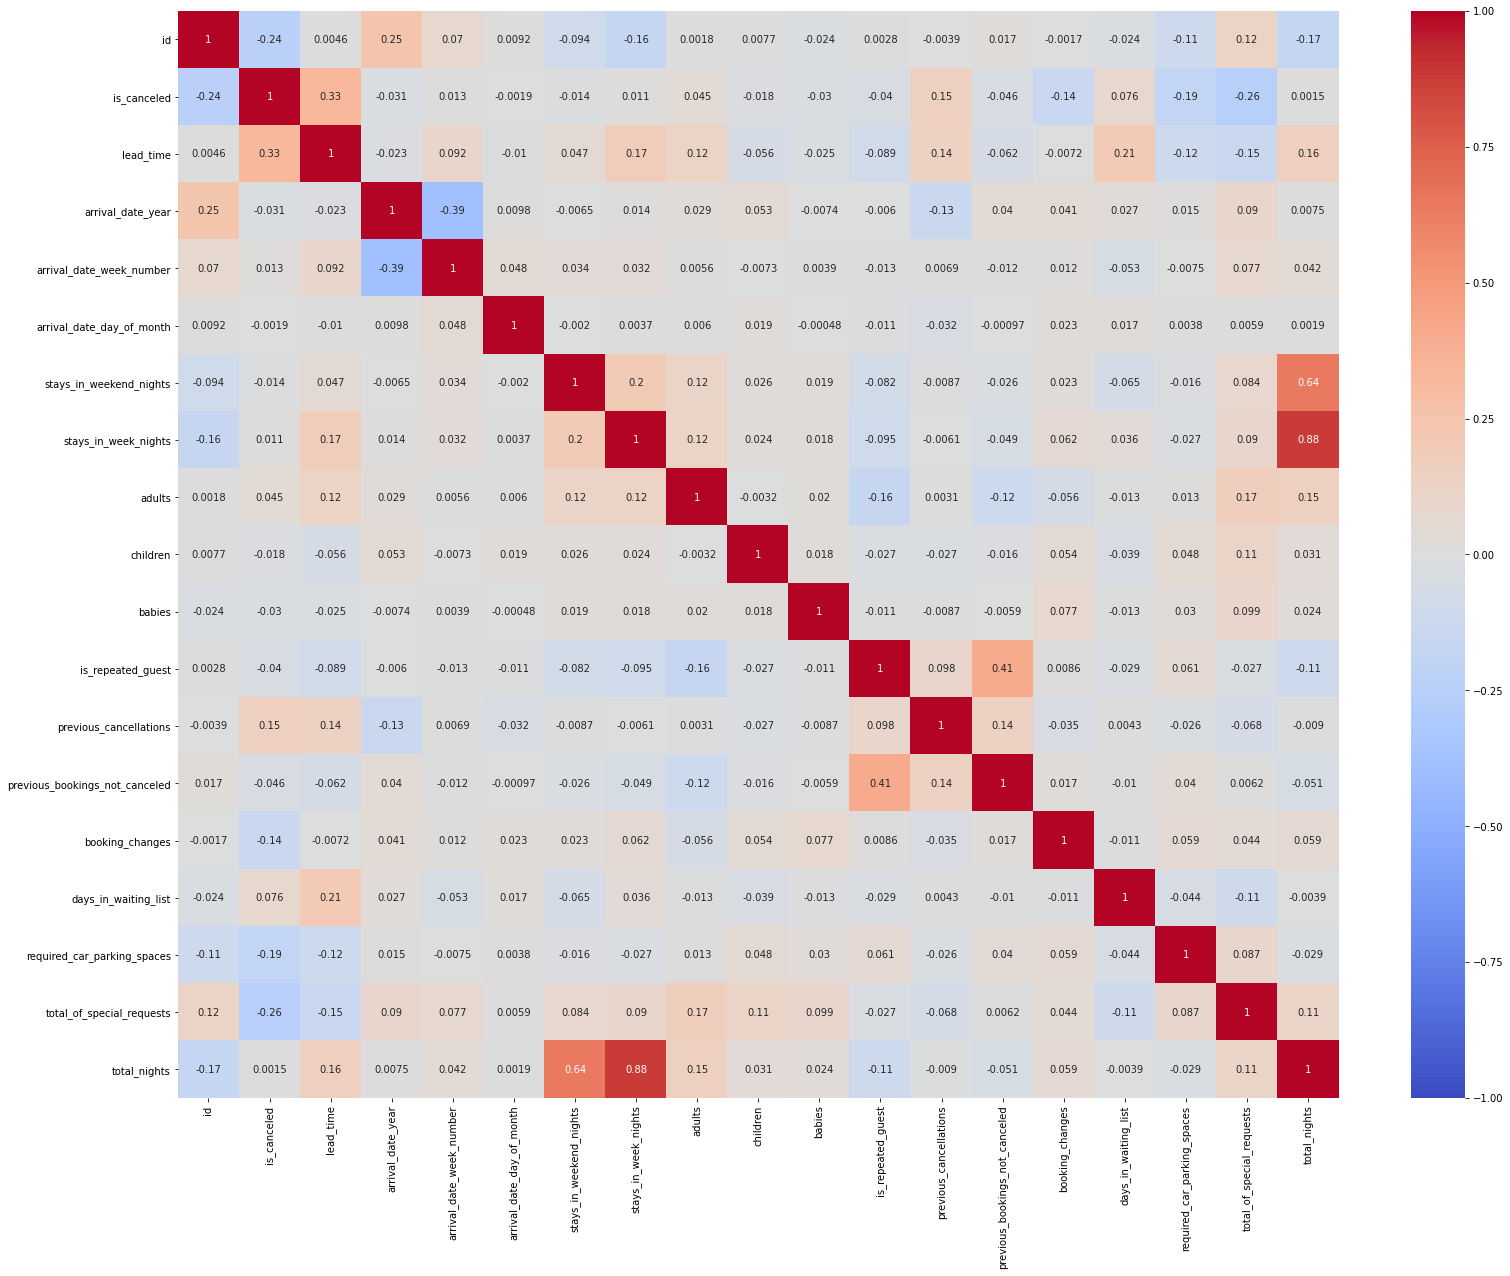

In [6]:
fig, ax = plt.subplots(figsize=(26, 20))


sns.heatmap(data.corr(), vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm')



* Напишем функцию, т.к. осмотр некоторых параметров будет проходить по схожуему образцу 

In [7]:
def inspect(row):
    display(row.sort_values().unique())
    display(row.dtype)
    display(row.value_counts())

### id — Номер записи

In [8]:
data['id'].head()

0    0
1    1
2    2
3    3
4    4
Name: id, dtype: int64

In [9]:
data['id'].duplicated().sum()

0

In [10]:
data_test['id'].duplicated().sum()

0

Столбец представляет из себя дубликат индексов. 
Его наличие не несёт смысловой нагрузки ->
Удаляем


##### **удаление столбца**

In [11]:
data = data.drop(['id'], axis = 1 )
data_test = data_test.drop(['id'], axis = 1)

#####   Дополнительная проверка ну дубликаты после удаления индекса

In [12]:
print(data.duplicated().sum(), '\n')
print(data_test.duplicated().sum())

21377 

7717


Количество дублей настолько большое, что отказ от такого количества данных может быть ошибочным. Подобное стоит уточнять у тех, кто собирал датасет. Это могут быть похожие заказы, сделанные в один день. 

### is_canceled — Отмена заказа

In [13]:
inspect(data['is_canceled'])

array([0, 1])

dtype('int64')

0    41185
1    24044
Name: is_canceled, dtype: int64

In [14]:
inspect(data_test['is_canceled'])

array([0, 1])

dtype('int64')

0    19821
1    12591
Name: is_canceled, dtype: int64

* Классы находятся в состоянии дисбаланса, что  корректирует выбор мерок точности и последующую проверку моделей с выравниванием по объему класса 

###  lead_time — Количество дней между датой бронирования и датой прибытия *

In [15]:
data['lead_time'].head()

0    7.00
1   14.00
2    0.00
3    9.00
4   85.00
Name: lead_time, dtype: float64

In [16]:
data['lead_time'].describe()

count   65,229.00
mean        96.34
std         96.13
min          0.00
25%         17.00
50%         64.00
75%        151.00
max        374.00
Name: lead_time, dtype: float64

<AxesSubplot:>

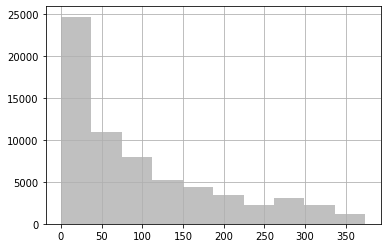

In [17]:
data['lead_time'].hist(color = 'silver')

<AxesSubplot:>

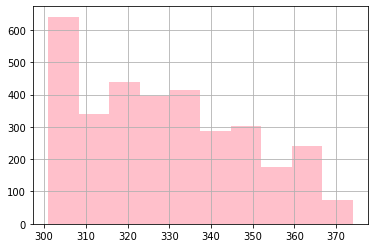

In [18]:
data[data['lead_time'] > 300]['lead_time'].hist(color = 'pink')

data


<AxesSubplot:xlabel='lead_time'>

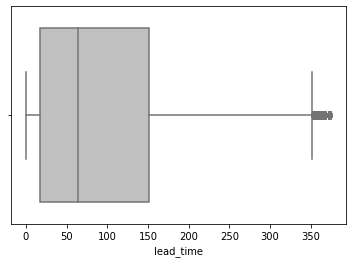

In [19]:
print('data')
sns.boxplot(data = data, x = 'lead_time', color = 'silver')


test_data


<AxesSubplot:xlabel='lead_time'>

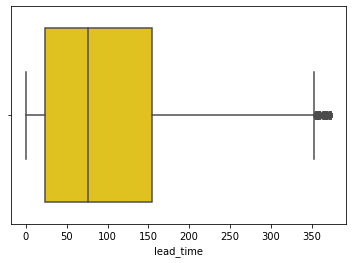

In [20]:
print('test_data')
sns.boxplot(data = data_test, x = 'lead_time', color = 'gold')

In [21]:
data['lead_time'].dtype  # *

dtype('float64')

* Удалим сильно выдающиеся значения и изменим тип данных

##### **Изменение типа переменной и удаление выбросов**

In [22]:
nindex_data = data[data['lead_time'] > 350]
data = data.drop(nindex_data.index).reset_index(drop = True)
 
nindex_data_t = data_test[data_test['lead_time'] > 350]
data_test = data_test.drop(nindex_data_t.index).reset_index(drop = True)                   

In [23]:
data['lead_time'] = data['lead_time'].astype(int)
data_test['lead_time'] = data_test['lead_time'].astype(int)

### arrival_date_year   — год заезда 

In [24]:
data['arrival_date_year'].head()

0    2015
1    2015
2    2015
3    2015
4    2015
Name: arrival_date_year, dtype: int64

In [25]:
data['arrival_date_year'].unique()

array([2015, 2016])

In [26]:
data_test['arrival_date_year'].unique()

array([2017])

In [27]:
data['arrival_date_year'].dtype

dtype('int64')

* Год не значимый параметр для обучения модели. Такая информацияя не повторится никогда в будущем и только загрузит модель ненужными данными.
* В дальнейшем - избавимся от этого параметра.

### arrival_date_month   — месяц заезда

In [28]:
data['arrival_date_month'].unique()

array(['July', 'August', 'September', 'October', 'November', 'December',
       'January', 'February', 'March', 'April', 'May', 'June'],
      dtype=object)

In [29]:
data_test['arrival_date_month'].unique()

array(['January', 'February', 'March', 'April', 'May', 'June', 'July',
       'August'], dtype=object)

Тестовая выборка не содержит информации по части месяцев и, видимо, взята за сравнительно не большой промежуток будущего времени. 

* Проверим количество данных за 2016 и 2015 год:

In [30]:
display(data[data['arrival_date_year'] == 2015]['arrival_date_month'].unique())
display(data[data['arrival_date_year'] == 2015]['arrival_date_month'].count())

array(['July', 'August', 'September', 'October', 'November', 'December'],
      dtype=object)

17994

In [31]:
display(data[data['arrival_date_year'] == 2016]['arrival_date_month'].unique())
display(data[data['arrival_date_year'] == 2016]['arrival_date_month'].count())

array(['January', 'February', 'March', 'April', 'May', 'June', 'July',
       'August', 'September', 'October', 'November', 'December'],
      dtype=object)

46668

In [32]:
display(data_test[data_test['arrival_date_year'] == 2017]['arrival_date_month'].count())

32225

Переведём месяцы в числовой вид, без участия энкодера, т.к. значения нам понадобятся в будующих рассчётах

##### **Изменения типа данных с object на int**

In [33]:
month_number = [7,8,9,10,11,12,1,2,3,4,5,6]
month_list = data['arrival_date_month'].unique()
data_list = [data, data_test]

In [34]:
for d in data_list:
    for i in range(len(month_list)):   
        d.loc[d['arrival_date_month'] == month_list[i], 'arrival_date_month'] = month_number[i]
    d['arrival_date_month'] = d['arrival_date_month'].astype(int)


In [35]:
data['arrival_date_month'].value_counts()

10    8839
9     8772
8     6677
11    5756
7     5653
12    5491
4     4804
5     4677
6     4595
3     4148
2     3358
1     1892
Name: arrival_date_month, dtype: int64

In [36]:
data_test['arrival_date_month'].value_counts()

5    5220
4    4825
6    4516
3    4275
7    3611
2    3542
1    3145
8    3091
Name: arrival_date_month, dtype: int64

* Месяц - самый важный параметр для подсчёта метрики прибыли. На его основе вычисляется надбавочный коэффицент на стоимость номера.

### arrival_date_week_number   — неделя заезда *


In [37]:
data['arrival_date_week_number'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53])

Столбец носит промежуточный объем данных между месяцем и днём заезда - теоретически, его можно заменить двумя другими столбцами, или он заменит их.

### arrival_date_day_of_month   — день заезда **


In [38]:
data['arrival_date_day_of_month'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [39]:
data_test['arrival_date_day_of_month'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

* Наличие параметра дня заселения не вызывает практической надобности, если при переходе на месяц нового сезона не изменяется коэффицент оплаты клиента. (Пример: клиент заселяется в последний день мая, платя по тарифу х1.2 один день, а все те, которые будут проведены в июне - по тарифу х1.4) Такой информации у нас нету, поэтому будем предполагать неизменные коэффиценты стоимости. Следовательно - наличие столбца под вопросом, как и года.

### stays_in_weekend_nights  -  количество ночей в выходные дни    

In [40]:
inspect(data['stays_in_weekend_nights'])

array([0, 1, 2, 3, 4])

dtype('int64')

0    29435
1    17555
2    17264
3      260
4      148
Name: stays_in_weekend_nights, dtype: int64

In [41]:
inspect(data_test['stays_in_weekend_nights'])

array([0, 1, 2, 3, 4])

dtype('int64')

0    13796
2     9170
1     9088
3      101
4       70
Name: stays_in_weekend_nights, dtype: int64

###  stays_in_week_nights — количество ночей в будние дни

In [42]:
inspect(data['stays_in_week_nights'])

array([0, 1, 2, 3, 4, 5, 6])

dtype('int64')

2    19842
1    17695
3    12314
5     5116
4     5081
0     3987
6      627
Name: stays_in_week_nights, dtype: int64

In [43]:
inspect(data_test['stays_in_week_nights'])

array([0, 1, 2, 3, 4, 5, 6])

dtype('int64')

2    8974
1    8008
3    7245
4    2968
5    2833
0    1934
6     263
Name: stays_in_week_nights, dtype: int64

###  adults — количество взрослых постояльцев

In [44]:
inspect(data['adults'])

array([0., 1., 2., 3., 4.])

dtype('float64')

2.00    48465
1.00    13162
3.00     2856
0.00      166
4.00       13
Name: adults, dtype: int64

In [45]:
inspect(data_test['adults'])

array([0., 1., 2., 3., 4.])

dtype('float64')

2.00    24070
1.00     6267
3.00     1811
0.00       68
4.00        9
Name: adults, dtype: int64

Возникает вопрос - что из себя представляют номера с 0'ым количеством взрослых жильцов. 

Посмотрим количество строк по наличию постояльцев - детей и совершено пустых.

In [46]:
print('Обучающая выборка')
print('Всего номеров без взрослых постояльцев:',data[data['adults'] == 0]['adults'].count())
print('Всего номеров, где постояльцами являются дети:',data[(data['adults'] == 0) & (data['children'] > 0)]['adults'].count())
print('Номеров где нету постояльцев:', data[(data['adults'] == 0) & (data['children'] == 0)]['adults'].count())

print('\n','Тестовая выборка')
print('Всего номеров без взрослых постояльцев:',data_test[data_test['adults'] == 0]['adults'].count())
print('Всего номеров, где постояльцами являются дети:',data_test[(data_test['adults'] == 0) & (data_test['children'] > 0)]['adults'].count())
print('Номеров где нету постояльцев:', data_test[(data_test['adults'] == 0) & (data_test['children'] == 0)]['adults'].count())

Обучающая выборка
Всего номеров без взрослых постояльцев: 166
Всего номеров, где постояльцами являются дети: 151
Номеров где нету постояльцев: 15

 Тестовая выборка
Всего номеров без взрослых постояльцев: 68
Всего номеров, где постояльцами являются дети: 61
Номеров где нету постояльцев: 7


In [47]:
display(data[(data['adults'] == 0)&(data['customer_type'] == 'Group' )]['children'])
display(data_test[(data_test['adults'] == 0)&(data['customer_type'] == 'Group' )]['children'])

45996   2.00
Name: children, dtype: float64

/tmp/ipykernel_168/1987589540.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(data_test[(data_test['adults'] == 0)&(data['customer_type'] == 'Group' )]['children'])


10380   2.00
Name: children, dtype: float64

In [48]:
display(data[(data['adults'] == 0) & (data['children'] == 0)])
display(data_test[(data_test['adults'] == 0) & (data_test['children'] == 0)])

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
23689,0,48,2016,2,9,21,2,4,0.00,0.00,...,0,0,0,B,2,0,Transient-Party,0,0,6
26797,0,122,2016,5,19,5,2,4,0.00,0.00,...,0,0,0,E,3,0,Transient,0,0,6
26798,0,122,2016,5,19,5,2,4,0.00,0.00,...,0,0,0,E,3,0,Transient,0,0,6
31361,0,256,2016,8,35,21,3,5,0.00,0.00,...,0,0,0,A,1,0,Transient,0,0,8
40917,0,0,2015,11,49,30,1,2,0.00,0.00,...,1,0,1,A,2,0,Transient,0,0,3
50195,0,52,2016,4,18,30,2,4,0.00,0.00,...,0,0,0,E,2,0,Transient-Party,0,1,6
54332,0,108,2016,7,28,5,2,5,0.00,0.00,...,0,0,0,A,0,0,Transient,0,0,7
56125,0,4,2016,8,32,5,2,2,0.00,0.00,...,0,0,0,A,2,0,Transient,0,2,4
56841,0,88,2016,8,34,16,0,4,0.00,0.00,...,0,0,0,D,5,0,Transient,0,2,4
57867,0,36,2016,8,35,27,3,6,0.00,0.00,...,0,0,0,A,2,0,Transient,0,2,9


,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
18180,0,55,2017,3,10,5,2,0,0.00,0.00,...,1,1,9,A,2,0,Transient,1,0,2
21059,0,50,2017,3,9,1,0,3,0.00,0.00,...,0,0,0,A,1,0,Transient,0,1,3
25441,0,33,2017,5,19,9,0,1,0.00,0.00,...,0,0,0,E,3,0,Transient,0,0,1
28288,0,26,2017,6,25,19,1,4,0.00,0.00,...,0,0,0,D,2,0,Transient,0,1,5
28646,0,107,2017,6,26,27,0,3,0.00,0.00,...,0,0,0,A,1,0,Transient,0,0,3
29623,0,44,2017,7,28,15,1,1,0.00,0.00,...,0,0,0,A,2,0,Transient,0,0,2
29867,0,2,2017,7,28,15,2,5,0.00,0.00,...,0,0,0,A,1,0,Transient-Party,0,1,7


In [49]:
display(data[(data['adults'] == 0) & (data['children'] == 0)])
display(data_test[(data_test['adults'] == 0) & (data_test['children'] == 0)])

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
23689,0,48,2016,2,9,21,2,4,0.00,0.00,...,0,0,0,B,2,0,Transient-Party,0,0,6
26797,0,122,2016,5,19,5,2,4,0.00,0.00,...,0,0,0,E,3,0,Transient,0,0,6
26798,0,122,2016,5,19,5,2,4,0.00,0.00,...,0,0,0,E,3,0,Transient,0,0,6
31361,0,256,2016,8,35,21,3,5,0.00,0.00,...,0,0,0,A,1,0,Transient,0,0,8
40917,0,0,2015,11,49,30,1,2,0.00,0.00,...,1,0,1,A,2,0,Transient,0,0,3
50195,0,52,2016,4,18,30,2,4,0.00,0.00,...,0,0,0,E,2,0,Transient-Party,0,1,6
54332,0,108,2016,7,28,5,2,5,0.00,0.00,...,0,0,0,A,0,0,Transient,0,0,7
56125,0,4,2016,8,32,5,2,2,0.00,0.00,...,0,0,0,A,2,0,Transient,0,2,4
56841,0,88,2016,8,34,16,0,4,0.00,0.00,...,0,0,0,D,5,0,Transient,0,2,4
57867,0,36,2016,8,35,27,3,6,0.00,0.00,...,0,0,0,A,2,0,Transient,0,2,9


,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
18180,0,55,2017,3,10,5,2,0,0.00,0.00,...,1,1,9,A,2,0,Transient,1,0,2
21059,0,50,2017,3,9,1,0,3,0.00,0.00,...,0,0,0,A,1,0,Transient,0,1,3
25441,0,33,2017,5,19,9,0,1,0.00,0.00,...,0,0,0,E,3,0,Transient,0,0,1
28288,0,26,2017,6,25,19,1,4,0.00,0.00,...,0,0,0,D,2,0,Transient,0,1,5
28646,0,107,2017,6,26,27,0,3,0.00,0.00,...,0,0,0,A,1,0,Transient,0,0,3
29623,0,44,2017,7,28,15,1,1,0.00,0.00,...,0,0,0,A,2,0,Transient,0,0,2
29867,0,2,2017,7,28,15,2,5,0.00,0.00,...,0,0,0,A,1,0,Transient-Party,0,1,7


У нас нету точного отклика от отеля - могут ли подобным образом бронировать номера(возможно - соседние), как и возможность заселять в номер только детей до 14 лет, без взрослого постояльца. Однако, если второе мы допускаем - полное отсутствие постояльцев мы допускать не будем.

In [50]:
display(data[(data['adults'] == 0)&(data['customer_type'] == 'Group' )]['children'])
display(data_test[(data_test['adults'] == 0)&(data['customer_type'] == 'Group' )]['children'])

45996   2.00
Name: children, dtype: float64

/tmp/ipykernel_168/1987589540.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(data_test[(data_test['adults'] == 0)&(data['customer_type'] == 'Group' )]['children'])


10380   2.00
Name: children, dtype: float64

#####  **Удаление строк с нулевым количеством постояльцев и изменение типа данных:**

In [51]:
#Было:
#index_data = data[(data['adults'] == 0) & (data['children'] == 0)]
#index_test = data_test[(data_test['adults'] == 0) & (data_test['children'] == 0)]
# Стало:
index_data = data[data['adults'] == 0]  
index_test = data_test[data_test['adults'] == 0]

In [52]:
data = data.drop(index_data.index).reset_index(drop = True)
data_test = data_test.drop(index_test.index).reset_index(drop = True)

In [53]:
data['adults'] = data['adults'].astype(int)
data_test['adults'] = data_test['adults'].astype(int)

### children — количество детей от 3 до 14 лет

In [54]:
inspect(data['children'])

array([0., 1., 2., 3.])

dtype('float64')

0.00    61130
1.00     2163
2.00     1195
3.00        8
Name: children, dtype: int64

In [55]:
inspect(data_test['children'])

array([0., 1., 2., 3.])

dtype('float64')

0.00    30172
1.00     1388
2.00      594
3.00        3
Name: children, dtype: int64

##### **Изменение типа данных**

In [56]:
data['children'] = data['children'].astype(int)
data_test['children'] = data_test['children'].astype(int)

### babies  — количество младенцев

In [57]:
inspect(data['babies'])

array([ 0.,  1.,  2.,  9., 10.])

dtype('float64')

0.00     64048
1.00       443
2.00         3
9.00         1
10.00        1
Name: babies, dtype: int64

In [58]:
inspect(data_test['babies'])

array([0., 1., 2.])

dtype('float64')

0.00    31984
1.00      169
2.00        4
Name: babies, dtype: int64

Сомнительные значения в 9 и 10 детей

In [59]:
display(data[data['babies'] > 8])

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
22902,0,37,2016,1,3,12,0,2,2,0,...,0,0,0,D,1,0,Transient,0,1,2
40901,0,11,2015,10,42,11,2,1,1,0,...,0,0,0,A,1,0,Transient-Party,0,0,3


Избавимся от этих значений.

##### **Изменение типа данных и удаление строк в обучающей выборке**

In [60]:
#data_index_babies = data[data['babies'] > 8]
#data = data.drop(data_index_babies.index).reset_index(drop = True)

In [61]:
data['babies'] = data['babies'].astype(int)
data_test['babies'] = data_test['babies'].astype(int)

<div class="alert alert-warning">
<h2>Комментарий ревьюера<a class="tocSkip"></a></h2>
    
**Есть совет** ⚠️: все так, но бронирований с 2 младенцами тоже слишком мало, чтобы использовать их для прогноза, такие записи тоже лучше удалить или приравнять к 1. Тогда признак можно переименовать, например, в `has_babies`, чтобы обозначить его теперь уже бинарную природу</div>

<div class="alert alert-info">
    <b>Комментарий студента:</b>  + 
</div>

<div class="alert alert-success">
<h2>Комментарий ревьюера v2<a class="tocSkip"></a></h2>
    
**Отлично!** ✔️: 👍</div>

In [62]:
data = data.query('babies <= 1')
data_test = data_test.query('babies <= 1')

### meal   — опции заказа ***

In [63]:
inspect(data['meal'])

array(['BB       ', 'FB       ', 'HB       ', 'SC', 'SC       '],
      dtype=object)

dtype('O')

BB           51053
HB            7210
SC            5262
SC             515
FB             451
Name: meal, dtype: int64

In [64]:
inspect(data_test['meal'])

array(['BB       ', 'FB       ', 'HB       ', 'SC', 'SC       '],
      dtype=object)

dtype('O')

BB           24481
SC            5007
HB            2372
SC             258
FB              35
Name: meal, dtype: int64

* В будущем - будем кодировать эту категорию, а сейчас приведём категории к похожуему виду и избавимся от дубликата.

#####  **Изменение имени с соответственным удалением дубликата**

In [65]:
#data = data.replace({'meal':{'BB       ':'BB','FB       ':'FB','HB       ':'HB','SC       ':'SC'}})
#data_test = data_test.replace({'meal':{'BB       ':'BB','FB       ':'FB','HB       ':'HB','SC       ':'SC'}})

<div class="alert alert-success">
<h2>Комментарий ревьюера<a class="tocSkip"></a></h2>
    
**Отлично!** ✔️: хорошо, что заметил лишние пробелы!</div>

<div class="alert alert-warning">
<h2>Комментарий ревьюера<a class="tocSkip"></a></h2>
    
**Есть совет** ⚠️: но лучше убирать их не вручную, а с помощью метода `strip`, так меньше шанс где-либо ошибиться, например:
    
    df['meal'] = df['meal'].str.strip()
</div>

<div class="alert alert-info">
    <b>Комментарий студента:</b> + </div>

In [66]:
data['meal'] = data['meal'].str.strip()
data_test['meal'] = data_test['meal'].str.strip()

<div class="alert alert-success">
<h2>Комментарий ревьюера v2<a class="tocSkip"></a></h2>
    
**Отлично!** ✔️: 👍</div>

### country  — гражданство постояльца  ***          

In [67]:
inspect(data['country'])

array(['ABW', 'AGO', 'ALB', 'AND', 'ARE', 'ARG', 'ARM', 'ATA', 'AUS',
       'AUT', 'AZE', 'BDI', 'BEL', 'BEN', 'BFA', 'BGD', 'BGR', 'BHR',
       'BIH', 'BLR', 'BOL', 'BRA', 'BRB', 'BWA', 'CHE', 'CHL', 'CHN',
       'CIV', 'CMR', 'CN', 'COL', 'CPV', 'CRI', 'CUB', 'CYM', 'CYP',
       'CZE', 'DEU', 'DMA', 'DNK', 'DOM', 'DZA', 'ECU', 'EGY', 'ESP',
       'EST', 'ETH', 'FIN', 'FRA', 'GAB', 'GBR', 'GEO', 'GGY', 'GIB',
       'GLP', 'GNB', 'GRC', 'GUY', 'HKG', 'HND', 'HRV', 'HUN', 'IDN',
       'IMN', 'IND', 'IRL', 'IRN', 'IRQ', 'ISL', 'ISR', 'ITA', 'JAM',
       'JEY', 'JOR', 'JPN', 'KAZ', 'KEN', 'KHM', 'KNA', 'KOR', 'KWT',
       'LBN', 'LBY', 'LCA', 'LIE', 'LKA', 'LTU', 'LUX', 'LVA', 'MAC',
       'MAR', 'MCO', 'MDV', 'MEX', 'MKD', 'MLI', 'MLT', 'MMR', 'MNE',
       'MOZ', 'MUS', 'MWI', 'MYS', 'NAM', 'NGA', 'NIC', 'NLD', 'NOR',
       'NZL', 'OMN', 'PAK', 'PAN', 'PER', 'PHL', 'PLW', 'POL', 'PRI',
       'PRT', 'PRY', 'PYF', 'QAT', 'ROU', 'RUS', 'RWA', 'SAU', 'SEN',
       'SGP', 'SLV', 

dtype('O')

PRT    28313
FRA     5956
GBR     5036
ESP     4887
DEU     3866
       ...  
PYF        1
SYC        1
ZWE        1
RWA        1
IMN        1
Name: country, Length: 155, dtype: int64

In [68]:
inspect(data_test['country'])

array(['ABW', 'AGO', 'ALB', 'AND', 'ARE', 'ARG', 'ASM', 'ATA', 'ATF',
       'AUS', 'AUT', 'AZE', 'BEL', 'BGD', 'BGR', 'BHR', 'BHS', 'BIH',
       'BLR', 'BRA', 'CAF', 'CHE', 'CHL', 'CHN', 'CIV', 'CMR', 'CN',
       'COL', 'CPV', 'CRI', 'CUB', 'CYP', 'CZE', 'DEU', 'DNK', 'DOM',
       'DZA', 'ECU', 'EGY', 'ESP', 'EST', 'ETH', 'FIN', 'FJI', 'FRA',
       'FRO', 'GAB', 'GBR', 'GHA', 'GIB', 'GNB', 'GRC', 'GTM', 'HKG',
       'HRV', 'HUN', 'IDN', 'IMN', 'IND', 'IRL', 'IRN', 'IRQ', 'ISL',
       'ISR', 'ITA', 'JAM', 'JEY', 'JOR', 'JPN', 'KAZ', 'KEN', 'KIR',
       'KOR', 'KWT', 'LAO', 'LBN', 'LBY', 'LIE', 'LKA', 'LTU', 'LUX',
       'LVA', 'MAC', 'MAR', 'MCO', 'MDG', 'MDV', 'MEX', 'MLT', 'MNE',
       'MOZ', 'MRT', 'MUS', 'MYS', 'MYT', 'NCL', 'NGA', 'NLD', 'NOR',
       'NPL', 'NZL', 'PAK', 'PAN', 'PER', 'PHL', 'POL', 'PRI', 'PRT',
       'PRY', 'QAT', 'ROU', 'RUS', 'SAU', 'SDN', 'SEN', 'SGP', 'SLE',
       'SLV', 'SRB', 'STP', 'SUR', 'SVK', 'SVN', 'SWE', 'SYC', 'SYR',
       'TGO', 'THA', 

dtype('O')

PRT    9783
GBR    3878
FRA    3465
DEU    2353
ESP    1929
       ... 
LBY       1
PRI       1
SLE       1
ATF       1
MYT       1
Name: country, Length: 142, dtype: int64

### distribution_channel — канал дистрибуции заказа ***

In [69]:
inspect(data['distribution_channel'])

array(['Corporate', 'Direct', 'GDS', 'TA/TO'], dtype=object)

dtype('O')

TA/TO        53812
Direct        6827
Corporate     3753
GDS             99
Name: distribution_channel, dtype: int64

In [70]:
inspect(data_test['distribution_channel'])

array(['Corporate', 'Direct', 'GDS', 'TA/TO'], dtype=object)

dtype('O')

TA/TO        26836
Direct        3631
Corporate     1601
GDS             85
Name: distribution_channel, dtype: int64

### is_repeated_guest   — признак того, что гость бронирует номер второй раз

In [71]:
inspect(data['is_repeated_guest'])

array([0, 1])

dtype('int64')

0    62727
1     1764
Name: is_repeated_guest, dtype: int64

In [72]:
inspect(data_test['is_repeated_guest'])

array([0, 1])

dtype('int64')

0    31139
1     1014
Name: is_repeated_guest, dtype: int64

### previous_cancellations — количество отменённых заказов у клиента

In [73]:
inspect(data['previous_cancellations'])

array([ 0,  1,  2,  3,  4,  5,  6, 11, 13, 14, 19, 21, 24, 25, 26])

dtype('int64')

0     59193
1      5028
2        53
3        51
11       35
24       28
25       19
26       18
19       17
5        13
13       12
14       11
6         7
4         5
21        1
Name: previous_cancellations, dtype: int64

In [74]:
inspect(data_test['previous_cancellations'])

array([0, 1, 2, 3, 4, 5, 6])

dtype('int64')

0    31929
1      163
2       29
6       15
4       10
3        6
5        1
Name: previous_cancellations, dtype: int64

Странным выглядит отсутствие промежуточных значений в обучающей выборке: посмотрим вблизи 


<AxesSubplot:>

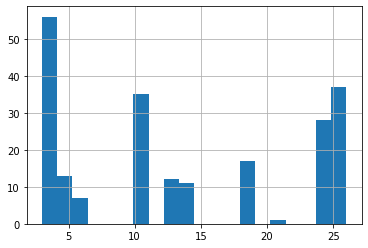

In [75]:
data[data['previous_cancellations']>2]['previous_cancellations'].hist(bins = 20)

In [76]:
display(data[data['previous_cancellations']>7])

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
6219,1,275,2015,10,41,4,2,0,2,0,...,0,26,0,A,0,0,Transient,0,0,2
6220,1,275,2015,10,41,4,2,0,2,0,...,0,26,0,A,0,0,Transient,0,0,2
6221,1,275,2015,10,41,4,2,0,2,0,...,0,26,0,A,0,0,Transient,0,0,2
6222,1,275,2015,10,41,4,2,0,2,0,...,0,26,0,A,0,0,Transient,0,0,2
6223,1,275,2015,10,41,4,2,0,2,0,...,0,26,0,A,0,0,Transient,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42173,1,190,2016,4,15,9,1,1,2,0,...,0,11,25,A,0,31,Transient-Party,0,0,2
42174,1,190,2016,4,15,9,1,1,2,0,...,0,11,25,A,0,31,Transient-Party,0,0,2
42175,1,190,2016,4,15,9,1,1,2,0,...,0,11,25,A,0,31,Transient-Party,0,0,2
42176,1,190,2016,4,15,9,1,1,2,0,...,0,11,25,A,0,31,Transient-Party,0,0,2


In [77]:
display(data[(data['previous_cancellations']>8)&(data['is_canceled']) == 1]['previous_cancellations'].count())

115

Строки с аномальным количеством прошлых отказов выглядят как большое количество ошибочных дубликатов.

#### **Удаление аномальных значений**

* за аномальные - примем все значения более 6.

In [78]:
cancel_index = data[data['previous_cancellations']>7]

In [79]:
data = data.drop(cancel_index.index).reset_index(drop = True)

### previous_bookings_not_canceled     — количество подтверждённых заказов у клиента

In [80]:
data['previous_bookings_not_canceled'].sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58])

<AxesSubplot:>

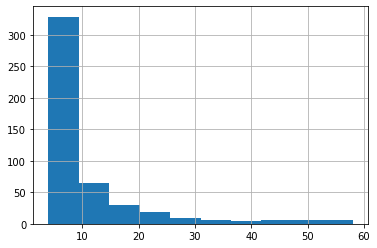

In [81]:
data[data['previous_bookings_not_canceled'] > 3]['previous_bookings_not_canceled'].hist()

In [82]:
data_test['previous_bookings_not_canceled'].sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 58, 59, 60,
       61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72])

<AxesSubplot:>

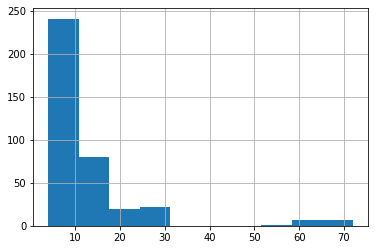

In [83]:
data_test[data_test['previous_bookings_not_canceled'] > 3]['previous_bookings_not_canceled'].hist()

### reserved_room_type — тип забронированной комнаты

In [84]:
inspect(data['reserved_room_type'])

array(['A               ', 'B               ', 'C               ',
       'D               ', 'E               ', 'F               ',
       'G               '], dtype=object)

dtype('O')

A                   49799
D                    9372
E                    2438
F                    1211
B                     712
G                     591
C                     227
Name: reserved_room_type, dtype: int64

In [85]:
inspect(data_test['reserved_room_type'])

array(['A               ', 'B               ', 'C               ',
       'D               ', 'E               ', 'F               ',
       'G               '], dtype=object)

dtype('O')

A                   23316
D                    6087
E                    1637
F                     501
G                     277
C                     200
B                     135
Name: reserved_room_type, dtype: int64

##### **Упрощение названий переменной**

In [86]:
data = data.replace({'reserved_room_type':{'A               ':'A','E               ':'E'
                                           ,'G               ':'G','D               ':'D'
                                           ,'F               ':'F','C               ':'C'
                                           ,'B               ':'B'}})

data_test = data_test.replace({'reserved_room_type':{'A               ':'A','E               ':'E'
                                           ,'G               ':'G','D               ':'D'
                                           ,'F               ':'F','C               ':'C'
                                           ,'B               ':'B'}})

### booking_changes  — количество изменений параметров заказа

In [87]:
inspect(data['booking_changes'])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 13, 14, 15, 16, 17])

dtype('int64')

0     55452
1      6526
2      1729
3       395
4       148
5        41
6        18
7        17
8         7
9         5
13        4
10        2
14        2
15        2
16        1
17        1
Name: booking_changes, dtype: int64

In [88]:
inspect(data_test['booking_changes'])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 14, 15, 16, 18])

dtype('int64')

0     27533
1      3035
2      1150
3       264
4       116
5        28
6        15
7         5
16        1
18        1
8         1
10        1
11        1
14        1
15        1
Name: booking_changes, dtype: int64

### days_in_waiting_list — сколько дней заказ ожидал подтверждения

In [89]:
inspect(data['days_in_waiting_list'])

array([  0,   1,   2,   3,   4,   5,   6,   8,   9,  10,  11,  12,  13,
        14,  15,  17,  19,  20,  21,  22,  24,  25,  27,  28,  30,  31,
        32,  33,  34,  35,  38,  39,  40,  41,  42,  43,  44,  45,  46,
        47,  48,  49,  50,  53,  55,  56,  57,  58,  59,  60,  61,  62,
        63,  65,  68,  69,  70,  71,  72,  74,  75,  76,  77,  79,  80,
        81,  85,  87,  89,  91,  93,  96,  98,  99, 101, 107, 108, 111,
       120, 122, 125, 142, 147, 150, 160, 162, 167, 174, 176, 178, 187,
       193, 207, 215, 224, 236, 259])

dtype('int64')

0      61145
39       185
58       164
44       137
31       107
       ...  
89         1
76         1
13         1
142        1
14         1
Name: days_in_waiting_list, Length: 97, dtype: int64

<AxesSubplot:xlabel='days_in_waiting_list'>

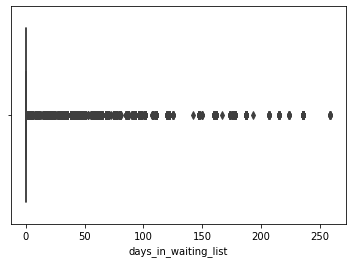

In [90]:
sns.boxplot(data = data, x = 'days_in_waiting_list')

<AxesSubplot:>

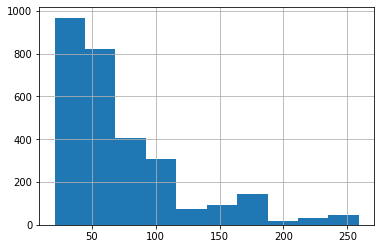

In [91]:
data[data['days_in_waiting_list']>20]['days_in_waiting_list'].hist()

379


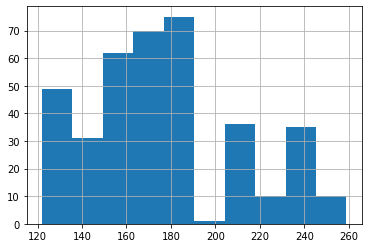

In [92]:
data[data['days_in_waiting_list']>120]['days_in_waiting_list'].hist()
print(data[data['days_in_waiting_list']>120]['days_in_waiting_list'].count())

In [93]:
inspect(data_test['days_in_waiting_list'])

array([  0,   1,   2,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  20,  21,  22,  23,  25,  26,  27,  28,
        30,  31,  32,  33,  34,  35,  36,  38,  39,  43,  44,  46,  47,
        49,  50,  53,  54,  56,  57,  59,  60,  61,  63,  64,  65,  71,
        73,  76,  80,  83,  84,  93,  98,  99, 100, 105, 107, 109, 111,
       113, 117, 121, 122, 154, 165, 175, 183, 185, 223])

dtype('int64')

0      31976
59         6
71         6
60         6
25         6
       ...  
57         1
73         1
105        1
121        1
223        1
Name: days_in_waiting_list, Length: 75, dtype: int64

<AxesSubplot:xlabel='days_in_waiting_list'>

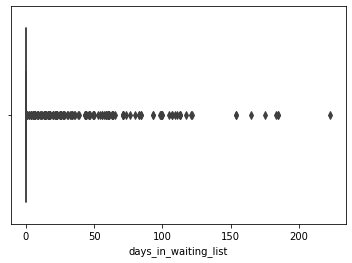

In [94]:
sns.boxplot(data = data_test, x = 'days_in_waiting_list')

<AxesSubplot:>

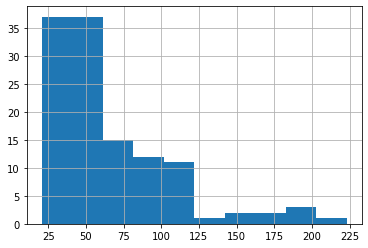

In [95]:
data_test[data_test['days_in_waiting_list']>20]['days_in_waiting_list'].hist()

10


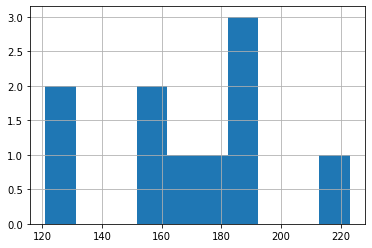

In [96]:
data_test[data_test['days_in_waiting_list']>120]['days_in_waiting_list'].hist()
print(data_test[data_test['days_in_waiting_list']>120]['days_in_waiting_list'].count())

* Время ожидания подтверждения заказа свыше 120 дней(примем это значение за точку отсечения) не укладываются в нормальное распределение.


#### **Удаление строк с аномальным значением времени ожидания подтверждения заказа**

In [97]:
waiting_data = data[data['days_in_waiting_list']> 120]
waiting_test = data_test[data_test['days_in_waiting_list']> 120]

In [98]:
data = data.drop(waiting_data.index).reset_index(drop = True)
data_test = data_test.drop(waiting_test.index).reset_index(drop = True)

### customer_type   — тип заказчика ***

In [99]:
inspect(data['customer_type'])

array(['Contract', 'Group', 'Transient', 'Transient-Party'], dtype=object)

dtype('O')

Transient          45054
Transient-Party    16013
Contract            2623
Group                281
Name: customer_type, dtype: int64

In [100]:
inspect(data_test['customer_type'])

array(['Contract', 'Group', 'Transient', 'Transient-Party'], dtype=object)

dtype('O')

Transient          27261
Transient-Party     4367
Contract             356
Group                159
Name: customer_type, dtype: int64

### required_car_parking_spaces  — необходимость места для автомобиля

In [101]:
inspect(data['required_car_parking_spaces'])

array([0, 1, 2, 3])

dtype('int64')

0    60308
1     3651
2       11
3        1
Name: required_car_parking_spaces, dtype: int64

In [102]:
display(data[data['required_car_parking_spaces'] > 1])

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
1568,0,122,2015,10,43,22,1,3,2,0,...,0,0,0,D,0,0,Transient,2,2,4
4034,0,225,2016,5,22,26,2,3,2,0,...,0,0,0,A,2,0,Transient-Party,2,0,5
7172,0,199,2015,9,36,3,0,3,1,0,...,0,0,0,D,0,0,Transient-Party,2,2,3
10730,0,36,2016,3,11,10,2,5,2,0,...,0,0,0,A,0,0,Transient,2,2,7
11136,0,0,2016,3,14,27,2,1,2,0,...,0,0,0,E,0,0,Transient,2,1,3
11224,0,169,2016,3,14,31,1,3,2,0,...,0,0,0,A,0,0,Transient-Party,2,0,4
11941,0,3,2016,4,18,30,1,1,2,0,...,0,0,0,D,0,0,Transient,2,0,2
12533,0,223,2016,5,22,24,1,5,2,0,...,0,0,0,A,4,0,Transient-Party,2,0,6
13579,0,180,2016,8,32,1,1,4,2,1,...,0,0,0,A,3,0,Transient,2,3,5
14001,0,139,2016,9,37,5,1,5,2,0,...,0,0,0,A,0,0,Transient-Party,2,1,6


In [103]:
inspect(data_test['required_car_parking_spaces'])

array([0, 1, 2, 3, 8])

dtype('int64')

0    30672
1     1463
2        6
3        1
8        1
Name: required_car_parking_spaces, dtype: int64

In [104]:
display(data_test[data_test['required_car_parking_spaces'] >1])

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
2482,0,5,2017,3,10,10,0,2,2,1,...,1,0,0,G,1,0,Transient,2,2,2
2528,0,26,2017,3,11,14,0,5,2,0,...,1,0,2,E,1,0,Transient-Party,8,1,5
2791,0,7,2017,1,2,11,0,2,2,0,...,0,0,0,A,0,0,Transient,2,1,2
3225,0,0,2017,1,4,27,0,2,2,2,...,0,0,0,G,0,0,Transient-Party,2,0,2
3226,0,0,2017,1,5,29,1,0,2,2,...,1,0,0,G,0,0,Transient-Party,2,0,1
3255,0,43,2017,1,4,27,1,2,2,0,...,0,0,0,A,0,0,Transient-Party,2,1,3
4173,0,5,2017,2,9,28,1,5,2,0,...,0,0,0,A,1,0,Transient-Party,2,0,6
24813,0,30,2017,4,17,29,2,1,2,0,...,0,0,0,A,0,0,Transient-Party,3,2,3


* ~~Нет точной информации о допустимом максимуме количества мест для автомобиля. Допускаем возможность бронирования номера с 2мя местами для автомобиля для двух взрослых людей - три и более места смотрятся неестественно.~~

Удалим незначительное количество строк с местами для автомобилей более 1'ого. Превратив его в бинарный признак.

#### **Удаление аномальных значений**

In [107]:
data = data.query('required_car_parking_spaces <= 1')
data_test = data_test.query('required_car_parking_spaces <= 1')

### total_of_special_requests — количество специальных отметок

In [108]:
inspect(data['total_of_special_requests'])

array([0, 1, 2, 3, 4, 5])

dtype('int64')

0    39587
1    16820
2     6409
3     1027
4      104
5       12
Name: total_of_special_requests, dtype: int64

In [109]:
inspect(data_test['total_of_special_requests'])

array([0, 1, 2, 3, 4, 5])

dtype('int64')

0    17175
1     9974
2     3949
3      896
4      123
5       18
Name: total_of_special_requests, dtype: int64

### total_nights  — общее количество ночей

In [110]:
inspect(data['total_nights'])

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

dtype('int64')

2     16256
3     15477
1     12042
4      9374
5      4190
7      3807
6      2012
8       537
9       149
10      115
Name: total_nights, dtype: int64

<AxesSubplot:xlabel='total_nights'>

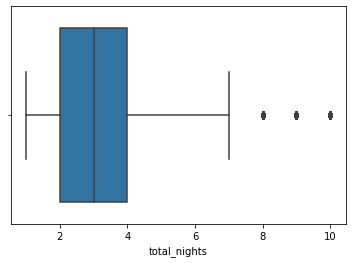

In [111]:
sns.boxplot(data = data, x = 'total_nights')

<AxesSubplot:>

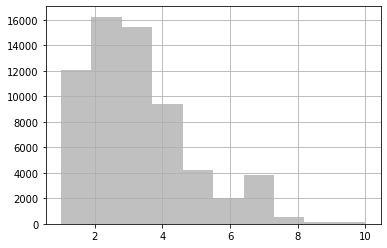

In [112]:
data['total_nights'].hist(bins = 10, color = 'silver')

In [113]:
inspect(data_test['total_nights'])

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

dtype('int64')

3     8295
2     6741
4     5774
1     5422
5     2401
7     2244
6      930
8      211
9       62
10      55
Name: total_nights, dtype: int64

<AxesSubplot:xlabel='total_nights'>

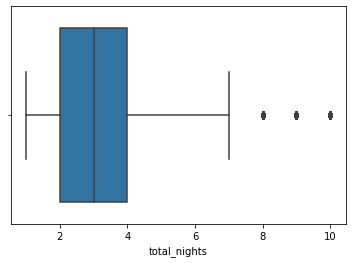

In [114]:
sns.boxplot(data = data_test, x = 'total_nights')

<AxesSubplot:>

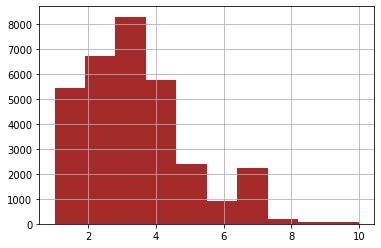

In [115]:
data_test['total_nights'].hist(bins = 10, color = 'brown')

* **Распределение выглядит естественно. Большие значения представленны не единичными случаями, а вполне правдоподобной арендой, сроком в 10 дней - без изменений.**

### Заключение:

* В результате первичной обработки были удалены столбцы носящие нежелательную информацию: id и номер недели заезда клиента.

* Удалены выдающиеся значения строк, изменены скрытые дубликаты в столбцах с категориальными значениями

* В последствии будет произведено разбиение массивов данных на два, посчитаны метрики и перекодированы категориальные столбцы для обучения ML-моделей

* **Тестовая выборка представлена не полным годом(12 месяцев), а только 8'ю месяцами**

* Выявлено огромное количество дубликатов, стоставляющих почти половину выборки. Информации по этой проблеме нету, поэтому данный факт остаётся без изменений, ввиду болезненного избавления от них.

## Постобработка. Бизнес метрика.

### Массивы для метрик

По условию: прибыль подсчитывается из типа номера(reserved_room_type) * количество ночей(total_nights) + разовое обслуживание, производимое раз в два дня. * сезонная наценка зависящая от месяца(arrival_date_month). Убытки представленны потерей от отмены заказа.(стоимость одной ночи + одно обслуживание)

In [116]:
data_metrics = data.loc[:,['reserved_room_type','total_nights', 'arrival_date_month','arrival_date_year','is_canceled']]
display(data_metrics)

,reserved_room_type,total_nights,arrival_date_month,arrival_date_year,is_canceled
0,A,1,7,2015,0
1,A,2,7,2015,0
2,C,2,7,2015,0
3,C,2,7,2015,0
4,A,3,7,2015,1
...,...,...,...,...,...
63966,D,6,12,2016,0
63967,D,5,12,2016,0
63968,D,6,12,2016,0
63969,A,7,12,2016,0


In [117]:
data_test_metrics = data_test.loc[:,['reserved_room_type','total_nights', 'arrival_date_month','arrival_date_year','is_canceled']]
display(data_test_metrics)

,reserved_room_type,total_nights,arrival_date_month,arrival_date_year,is_canceled
0,A,1,1,2017,1
1,A,4,1,2017,1
2,A,4,1,2017,1
3,A,4,1,2017,1
4,A,7,1,2017,1
...,...,...,...,...,...
32138,A,6,8,2017,0
32139,A,7,8,2017,0
32140,A,7,8,2017,0
32141,D,7,8,2017,0


#### **Дополнение массивов метрик коэффицентами и выручкой от сдачи номера.**

* **Создадим функции добавляющие новые столбцы для подсчёта бизнес метрик по новым массивам:**

In [ ]:
spring = [3,4,5]
summer = [6,7,8]
winter = [12,1,2]
autumn = [9,10,11]

month_list = [spring, summer, winter, autumn]
coef = [1.2,1.4,1.0,1.2]

class_list = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
room_prices = [1000,800,600,550,500,450,350]
service_price = [400,350,150,150,150,150,150]




def month_coef(data):
    for i in range(len(month_list)):
        if data['arrival_date_month'] in month_list[i]:
            return coef[i]

def price_service(data):
    for number in range(len(class_list)):
        if data['reserved_room_type'] == class_list[number]:
            return service_price[number]
    
def price_room(data):
    for number in range(len(class_list)):
        if data['reserved_room_type'] == class_list[number]:
            return room_prices[number]    
    
def income(data):
    if data['is_canceled'] == 0:
        return ((data['room_price'] * data['total_nights']) * data['season_coef']) - ((1 + data['total_nights']//2) * data['service_price']) 
    if data['is_canceled'] == 1:
        return - ((data['room_price'] * data['season_coef']) + data['service_price'])
    
def new_columns(data):
    for i in range(4):
        data[new_colums_list[i]] = data.apply(function_list[i], axis = 1)

new_colums_list = ['room_price','service_price','season_coef','income']
function_list = [price_room, price_service, month_coef, income]

~~def income(data):
    if data['is_canceled'] == 0:
        return ((data['room_price'] * data['total_nights']) 
                + (data['service_price'] * data['total_nights']//2)) * data['season_coef']
    if data['is_canceled'] == 1:
        return (-data['room_price'] - data['service_price'])~~

<div class="alert alert-info">
    <b>Комментарий студента:</b> Функцию поменял, значительно ошибся - извиняюсь</div>

In [119]:
new_columns(data_metrics)
new_columns(data_test_metrics)

In [ ]:
display(data_metrics)

,reserved_room_type,total_nights,arrival_date_month,arrival_date_year,is_canceled,room_price,service_price,season_coef,income
0,A,1,7,2015,0,1000,400,1.40,"1,000.00"
1,A,2,7,2015,0,1000,400,1.40,"2,000.00"
2,C,2,7,2015,0,600,150,1.40,"1,380.00"
3,C,2,7,2015,0,600,150,1.40,"1,380.00"
4,A,3,7,2015,1,1000,400,1.40,"-1,800.00"
...,...,...,...,...,...,...,...,...,...
63966,D,6,12,2016,0,550,150,1.00,"2,700.00"
63967,D,5,12,2016,0,550,150,1.00,"2,300.00"
63968,D,6,12,2016,0,550,150,1.00,"2,700.00"
63969,A,7,12,2016,0,1000,400,1.00,"5,400.00"


In [121]:
print('Прибыль за 2015 год:',data_metrics[data_metrics['arrival_date_year'] == 2015]['income'].sum())
print('Значений за 2015 год:',data_metrics[data_metrics['arrival_date_year'] == 2015]['income'].count())
print('Прибыль за 2016 год',data_metrics[data_metrics['arrival_date_year'] == 2016]['income'].sum())
print('Значений за 2016 год:', data_metrics[data_metrics['arrival_date_year'] == 2016]['income'].count())
print('Прибыль за 2017 год',data_test_metrics[data_test_metrics['arrival_date_year'] == 2017]['income'].sum())
print('Значений за 2017 год:', data_test_metrics[data_test_metrics['arrival_date_year'] == 2017]['income'].count())

Прибыль за 2015 год: 18040950.0
Значений за 2015 год: 17843
Прибыль за 2016 год 47967600.0
Значений за 2016 год: 46116
Прибыль за 2017 год 32544740.0
Значений за 2017 год: 32135


## Подготовка данных для ML модели

### Корреляция

Повторно просмотрим корреляцию между столбцами, определим какие уйдут под дроп, а какие под кодировку

<AxesSubplot:>

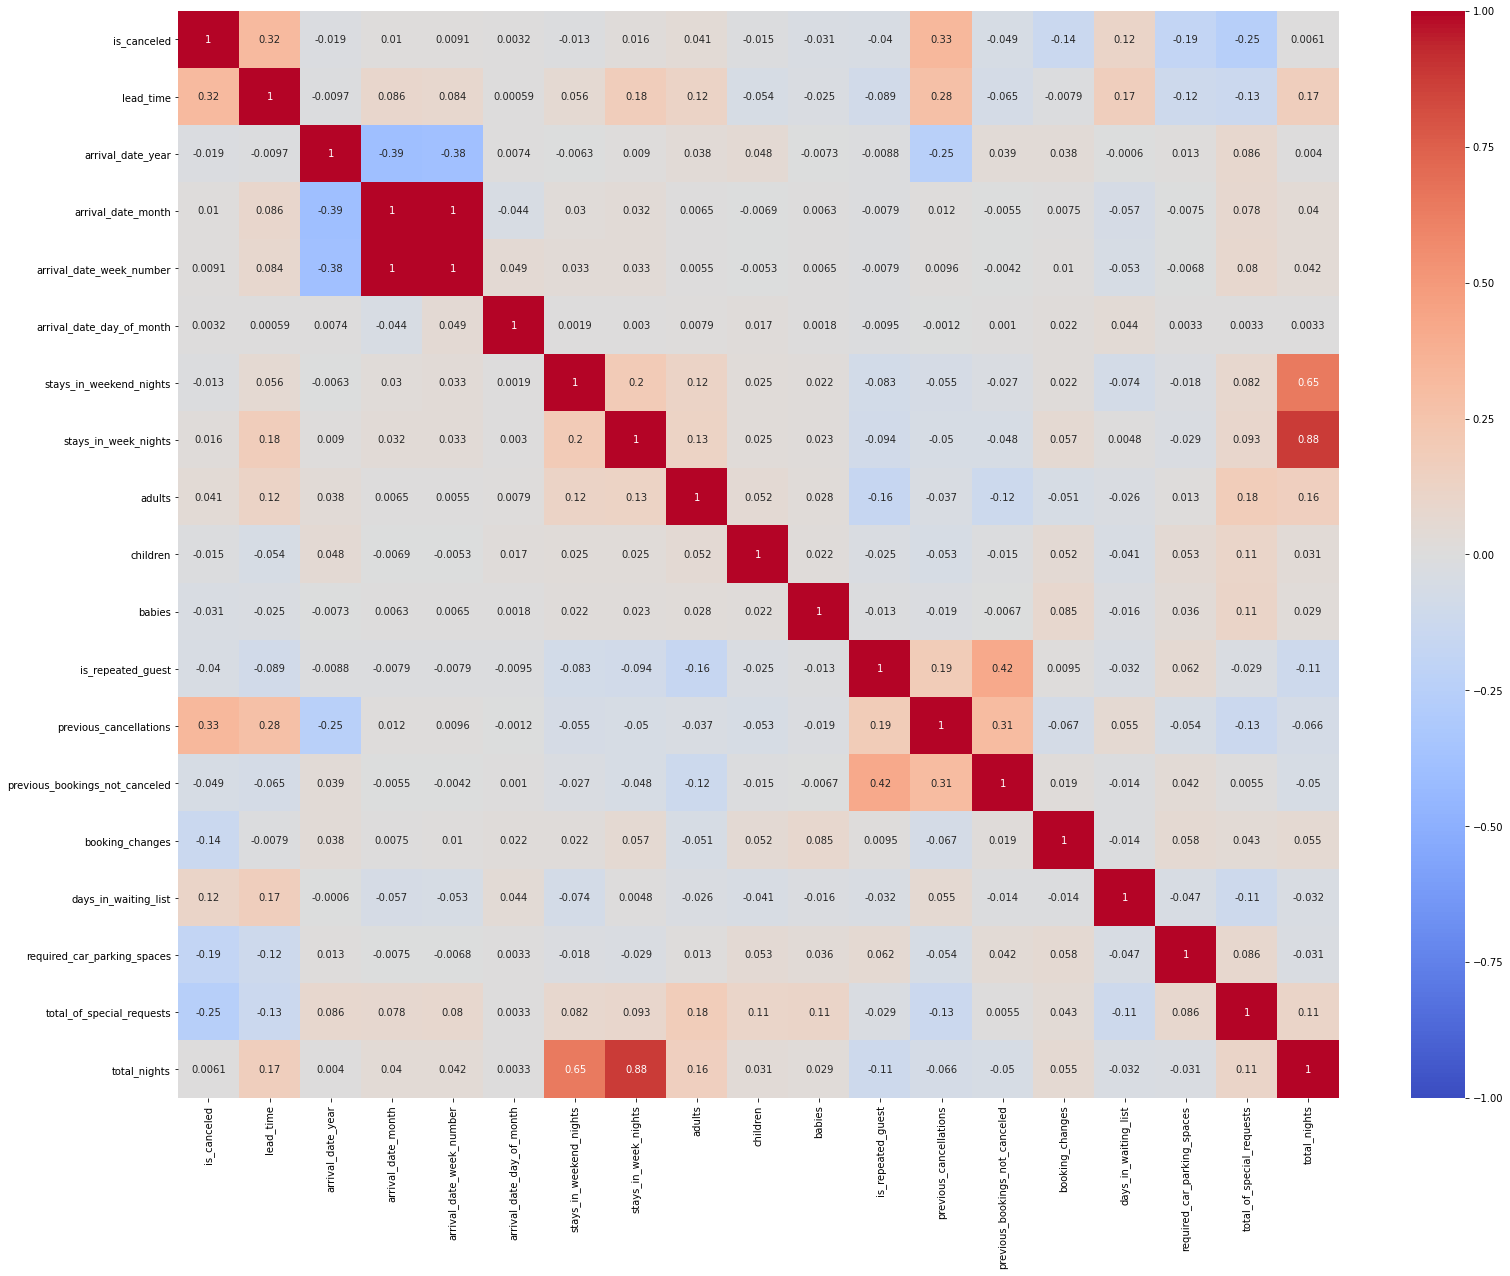

In [122]:
fig, ax = plt.subplots(figsize=(26, 20))


sns.heatmap(data.corr(), vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm')

* arrival_date_year - нецикличный признак, со значениями которого модель в будущем не столкнётся - удаляем.


* arrival_date_month & arrival_date_day_of_month можно заменить одним arrival_date_week_number, чтобы снизить общую нагрузку


* stays_in_weekend_nights & satys_in_week_nights очень сильно коррелируют с total_nights, в то же время корреляция total_night и целевого признакак is_canceled менее весома чем у двух остальны. - удалим total_nights.

* distribution_channel - не связан со взаимодействием клиента и сервиса, следовательно - не должен влиять на отмену брони, вне зависимости от корреляции в матрице

In [ ]:
data_ml = data.drop(['arrival_date_year','arrival_date_month','arrival_date_day_of_month','total_nights','distribution_channel'], axis = 1)
data_test_ml = data_test.drop(['arrival_date_year','arrival_date_month','arrival_date_day_of_month','total_nights','distribution_channel'], axis = 1)
#display(data_ml.head())
#display(data_test_ml.head())

* Категориальные признаки требуют дальнейшей обработки. Бдуем использовать OneHotEncoder 

### Создание основной выборки:

In [124]:
features_train, target_train = data_ml.drop(columns = 'is_canceled', axis = 1), data_ml['is_canceled']

features_test, target_test = data_test_ml.drop(columns = 'is_canceled', axis = 1), data_test_ml['is_canceled']

In [125]:
ohe = OneHotEncoder(sparse=False,handle_unknown ='ignore')

In [126]:
ohe.fit(features_train)
features_train_main = ohe.transform(features_train)
features_test = ohe.transform(features_test)

### Создание выборки с удалением дубликатов:

* Создадим отдельную выборку для обучения модели, в которой дропним все дубликаты найденные в dataframe


In [127]:
dfdr = data.drop_duplicates()
display(dfdr.shape)
print(dfdr['is_canceled'].value_counts())

(43458, 24)

0    32418
1    11040
Name: is_canceled, dtype: int64


In [128]:
dfdr_metrics = dfdr.loc[:,['reserved_room_type','total_nights', 'arrival_date_month','arrival_date_year','is_canceled']]
dfdr_ml = dfdr.drop(['arrival_date_year','arrival_date_month','arrival_date_day_of_month','total_nights','distribution_channel'], axis = 1)

In [129]:
features_train_dr, target_train_dr = dfdr_ml.drop(columns = 'is_canceled', axis = 1), dfdr_ml['is_canceled']

In [130]:
ohe.fit(features_train)
features_train_drop = ohe.transform(features_train_dr)

## Подбор ML-модели

Т.к. задача представленна бинарной классификацией - будем использовать следующие модели:

* **LogisticRegression**
* **DecisionTreeClassifier**
* **RandomForestClassifier**

В теории, главная задача модели для бизнеса - максимальный успех предсказания целевого признака. Т.Е. min-FALSE-NEGATIV & max-TRUE POSITIVE, если ошибочные( FALSE POSITIVE ) предсказания не влияют на нашу выручку.
* **Recall(Полнота)** - показывает долю истинных положительных ответов от их реального числа(тех, которые модель определила как 0, когда фактически - они 1)

Если, FALSE POSITIVE имеет негативное влияние на клиента - нам важны точности Recall & Precision, гармоничное которых выражается в:
* **f1-мера** - учитывает одновременно точность и полноту.

**Модели обучим по лучшему результату для каждой из мерик**

**LogisticRegression**

In [134]:
scrng = ['recall', 'f1']
criter = ['entropy', 'gini']

In [135]:
def logreg(features, target):
    solv = ['liblinear', 'sag','lbfgs','saga']
    itr = [100,500,1000]
    for i in range(len(scrng)):
        best_model = 0
        best_score = 0
        for sol in range(len(solv)):
            for it in range(len(itr)):
                model = LogisticRegression(random_state=0, solver='liblinear',class_weight='balanced',max_iter=1000)
                model.fit(features, target)
                scores = cross_val_score(model, features, target, cv = 5,scoring = scrng[i])
                final_score = pd.Series(scores).mean()
                if final_score > best_score:
                    best_score = final_score
                    best_model = model
        print('Финальная точность модели LogisticRegression по',scrng[i],':', final_score)
        print('Лучшая модель:', best_model)
        

**DecisionTreeClassifier**

In [136]:
def dtc(features,target):
    spl = [2, 6, 10, 20, 40]
    criter = ['entropy', 'gini']
    for i in range(len(scrng)):        
        best_model = 0
        best_score = 0
        for depth in range(1,12,3):
            for split in range(len(spl)):
                for crit in range(len(criter)):
                    model = DecisionTreeClassifier(random_state=0, 
                                                 max_depth= depth, 
                                                 class_weight='balanced',
                                                 min_samples_split = spl[split],
                                                  splitter = 'best',
                                                  criterion = criter[crit])
                    model.fit(features, target)
                    scores = cross_val_score(model, features, target, cv = 5, scoring = scrng[i])  #scoring = 'f1'
                    final_score = pd.Series(scores).mean()
                    if final_score > best_score:
                        best_score = final_score
                        best_model = model
        print('Финальная точность модели DecisionTreeClassifier по',scrng[i],':', best_score)
        print('Cледующие параметры модели:', best_model)

**RandomForestClassifier**

In [137]:
def rfc(features, target):
    spl = [2, 10, 20]
    criter = ['entropy', 'gini']
    for i in range(len(scrng)):
        best_model = 0
        best_score_f = 0
        best_n_est_f = 0
        best_depth_f = 0
        for est in range(1,50,10):
            for depth in range(1,10):
                for split in range(len(spl)):
                    for crit in range(len(criter)):
                        model = RandomForestClassifier(random_state = 0,
                                                       n_estimators = est,
                                                       max_depth = depth,
                                                       min_samples_split = spl[split],
                                                        class_weight='balanced',
                                                       criterion = criter[crit])
                        scores = cross_val_score(model, features,target, cv = 5, scoring = scrng[i])
                        final_score = pd.Series(scores).mean()
                        if final_score > best_score_f:
                            best_score_f = final_score
                            best_model = model
        print('лучшая точность модели RandomForestClassifier по',scrng[i],':',best_score_f,'\n')
        print('Cледующие параметры модели:', best_model)

### Обучение моделей на исходной выборке

In [138]:
print(target_train.value_counts())

0    40689
1    23270
Name: is_canceled, dtype: int64


In [139]:
logreg(features_train_main, target_train)
dtc(features_train_main, target_train)
rfc(features_train_main, target_train)

Финальная точность модели LogisticRegression по recall : 0.5918349806617963
Лучшая модель: LogisticRegression(class_weight='balanced', max_iter=1000, random_state=0,
                   solver='liblinear')
Финальная точность модели LogisticRegression по f1 : 0.5396720089669557
Лучшая модель: LogisticRegression(class_weight='balanced', max_iter=1000, random_state=0,
                   solver='liblinear')
Финальная точность модели DecisionTreeClassifier по recall : 0.7490760636012033
Cледующие параметры модели: DecisionTreeClassifier(class_weight='balanced', max_depth=4, random_state=0)
Финальная точность модели DecisionTreeClassifier по f1 : 0.6520800434955707
Cледующие параметры модели: DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=7, min_samples_split=10, random_state=0)
лучшая точность модели RandomForestClassifier по recall : 0.738031800601633 

Cледующие параметры модели: RandomForestClassifier(class_weight='balanced', criterio

### Тест моделей с лучшей производительностью

#### DTC с лучшим результатом по recall:

score 0.7324374346181701
f1 0.6356145251396648
auc_roc 0.7518732964547871


Text(0.5, 1.0, 'ROC-кривая')

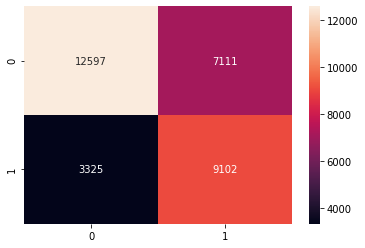

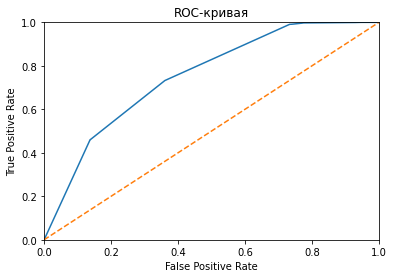

In [140]:
model = DecisionTreeClassifier(random_state=0, 
                                         max_depth= 4,
                              class_weight = 'balanced')
model.fit(features_train_main, target_train)
predict_test_dtc_r = model.predict(features_test)
probabilities_dtc_r = model.predict_proba(features_test)
probabilities_one_test_dtc_r = probabilities_dtc_r[:,1]

print('score', recall_score(target_test, predict_test_dtc_r))
print('f1', f1_score(target_test,predict_test_dtc_r))
print('auc_roc', roc_auc_score(target_test, probabilities_one_test_dtc_r))

sns.heatmap(confusion_matrix(target_test, predict_test_dtc_r), annot=True, fmt='g')
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test_dtc_r) 
plt.figure()
plt.plot(fpr,tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

* Из общего множества позитивного, целевого признака модель определила большую часть(что воспринимается нами позитивно), убавив в точности по этому признаку в целом.

#### DTC с лучшим результатом по f1:

score 0.6699122877605215
f1 0.6437519331889886
auc_roc 0.7959914232791105


Text(0.5, 1.0, 'ROC-кривая')

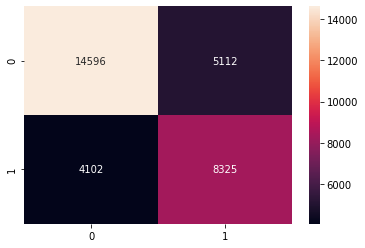

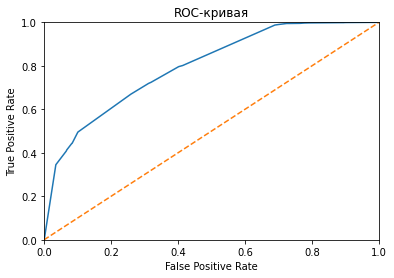

In [141]:
model = DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=7, min_samples_split=10, random_state=0)
model.fit(features_train_main, target_train)
predict_test_dtc_f = model.predict(features_test)
probabilities_dtc_f = model.predict_proba(features_test)
probabilities_one_test_dtc_f = probabilities_dtc_f[:,1]


print('score', recall_score(target_test, predict_test_dtc_f))
print('f1', f1_score(target_test,predict_test_dtc_f))
print('auc_roc', roc_auc_score(target_test, probabilities_one_test_dtc_f))

sns.heatmap(confusion_matrix(target_test, predict_test_dtc_f), annot=True, fmt='g')
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test_dtc_f) 
plt.figure()
plt.plot(fpr,tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')



* Гармоничная модель между Precision & Recall

#### RFC с лучшим результатом по recall:

score 0.7152168665003621
f1 0.6000945243400175
auc_roc 0.6827681351399867


Text(0.5, 1.0, 'ROC-кривая')

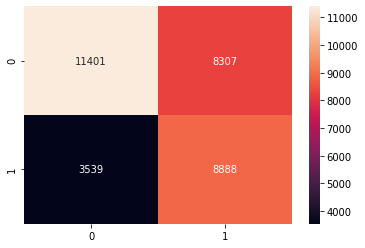

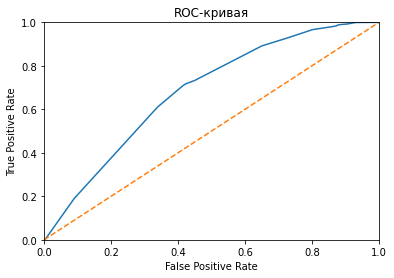

In [142]:
model = RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=7, n_estimators=1, random_state=0)
model.fit(features_train_main, target_train)
predict_test_rfc_r = model.predict(features_test)
probabilities_rfc_r = model.predict_proba(features_test)
probabilities_one_test_rfc_r = probabilities_rfc_r[:,1]

print('score', recall_score(target_test, predict_test_rfc_r))
print('f1', f1_score(target_test,predict_test_rfc_r))
print('auc_roc', roc_auc_score(target_test, probabilities_one_test_rfc_r))

sns.heatmap(confusion_matrix(target_test, predict_test_rfc_r), annot=True, fmt='g')
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test_rfc_r) 
plt.figure()
plt.plot(fpr,tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

#### RFC с лучшим результатом по f1:

score 0.42818057455540354
f1 0.5391903531438414
auc_roc 0.7513035391962044


Text(0.5, 1.0, 'ROC-кривая')

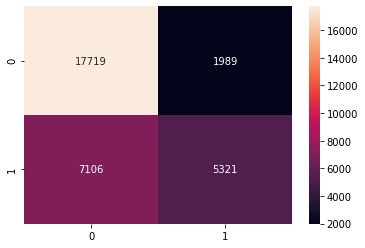

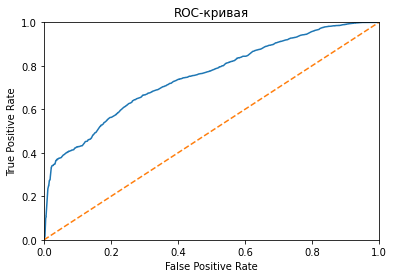

In [143]:
model = RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=3, min_samples_split=10, n_estimators=41,
                       random_state=0)
model.fit(features_train_main, target_train)
predict_test_rfc_f = model.predict(features_test)
probabilities_rfc_f = model.predict_proba(features_test)
probabilities_one_test_rfc_f = probabilities_rfc_f[:,1]

print('score', recall_score(target_test, predict_test_rfc_f))
print('f1', f1_score(target_test,predict_test_rfc_f))
print('auc_roc', roc_auc_score(target_test, probabilities_one_test_rfc_f))

sns.heatmap(confusion_matrix(target_test, predict_test_rfc_f), annot=True, fmt='g')
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test_rfc_f) 
plt.figure()
plt.plot(fpr,tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

### Dropduplicates

In [147]:
logreg(features_train_drop, target_train_dr)
dtc(features_train_drop, target_train_dr)
rfc(features_train_drop, target_train_dr)

Финальная точность модели LogisticRegression по recall : 0.4883152173913044
Лучшая модель: LogisticRegression(class_weight='balanced', max_iter=1000, random_state=0,
                   solver='liblinear')
Финальная точность модели LogisticRegression по f1 : 0.37959795829318377
Лучшая модель: LogisticRegression(class_weight='balanced', max_iter=1000, random_state=0,
                   solver='liblinear')
Финальная точность модели DecisionTreeClassifier по recall : 1.0
Cледующие параметры модели: DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=1, random_state=0)
Финальная точность модели DecisionTreeClassifier по f1 : 0.5244177307602411
Cледующие параметры модели: DecisionTreeClassifier(class_weight='balanced', max_depth=10, random_state=0)
лучшая точность модели RandomForestClassifier по recall : 0.8003623188405797 

Cледующие параметры модели: RandomForestClassifier(class_weight='balanced', max_depth=8,
                       min_sa

### Тест моделей с изменённой выборкой:

#### DTC по метрике recall:

score 1.0
f1 0.5766723125826585
auc_roc 0.537116906839862


Text(0.5, 1.0, 'ROC-кривая')

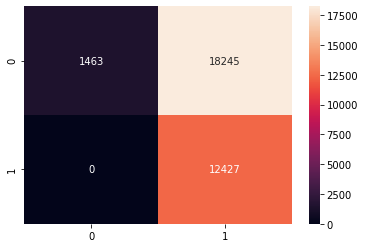

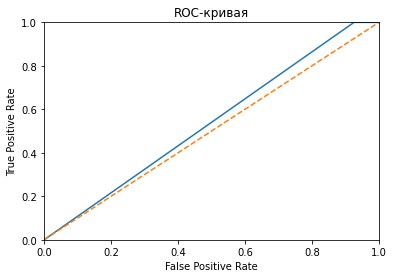

In [148]:
model = DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=1, random_state=0)
model.fit(features_train_drop, target_train_dr)
predict_test_drdtc = model.predict(features_test)
probabilities_drdtc = model.predict_proba(features_test)
probabilities_one_test_drdtc = probabilities_drdtc[:,1]

print('score', recall_score(target_test, predict_test_drdtc))
print('f1', f1_score(target_test,predict_test_drdtc))
print('auc_roc', roc_auc_score(target_test, probabilities_one_test_drdtc))

sns.heatmap(confusion_matrix(target_test, predict_test_drdtc), annot=True, fmt='g')
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test_drdtc) 
plt.figure()
plt.plot(fpr,tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

#Статичная модель, идеальнее статичной модели.

#### RFC по метрике recall:

score 0.49175183069123685
f1 0.5275379834254142
auc_roc 0.7051626066963766


Text(0.5, 1.0, 'ROC-кривая')

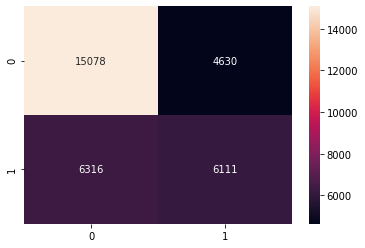

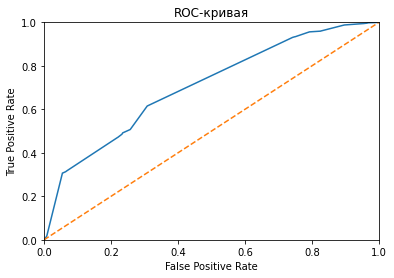

In [149]:
model = RandomForestClassifier(class_weight='balanced', max_depth=8,
                       min_samples_split=10, n_estimators=1, random_state=0)
model.fit(features_train_drop, target_train_dr)
predict_test_drrfc_r = model.predict(features_test)
probabilities_drrfc_r = model.predict_proba(features_test)
probabilities_one_test_drrfc_r = probabilities_drrfc_r[:,1]

print('score', recall_score(target_test, predict_test_drrfc_r))
print('f1', f1_score(target_test,predict_test_drrfc_r))
print('auc_roc', roc_auc_score(target_test, probabilities_one_test_drrfc_r))

sns.heatmap(confusion_matrix(target_test, predict_test_drrfc_r), annot=True, fmt='g')
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test_drrfc_r) 
plt.figure()
plt.plot(fpr,tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

##### Вывод по моделям изменённой выборки:

Модели построенные на изменённой выборке полностью уступают моделям подобранным на исходных данных. 

### Статичная модель:

accuracy 0.613287692547067
recall: 0.0
f1_score: 0.0
auc_roc_test: 0.5


Text(0.5, 1.0, 'ROC-кривая')

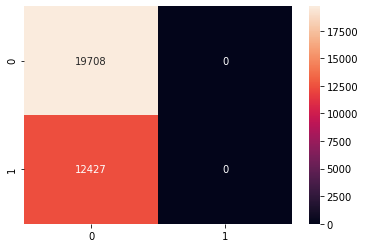

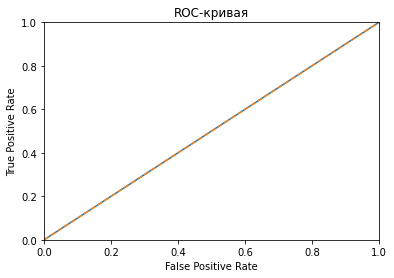

In [150]:
dum = DummyClassifier(strategy = 'prior', random_state = 0) 
dum.fit(features_train_main, target_train)
dum_predict = dum.predict(features_test)
dum_scor = dum.score(features_test, target_test)
probabilities_testcn = dum.predict_proba(features_test)
probabilities_one_testcn  = probabilities_testcn[:,1]
dum_recall = recall_score(target_test, dum_predict)
dum_f1_score = f1_score(target_test, dum_predict)
auc_roc_test = roc_auc_score(target_test, probabilities_one_testcn)
print('accuracy', dum_scor)
print('recall:', dum_recall)
print('f1_score:', dum_f1_score)
print('auc_roc_test:', auc_roc_test)


sns.heatmap(confusion_matrix(target_test, dum_predict), annot=True, fmt='g')
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_testcn) 
plt.figure()
plt.plot(fpr,tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')


### Выбор модели для дальнейших тестов по бизнес-метрике

Для дальнейших тестов будем использовать две модели из предложенного множества выше:
1. * **model = DecisionTreeClassifier**   (Лучшая f1)
   * гиперпараметры модели: **class_weight='balanced', criterion='entropy', max_depth=7, min_samples_split=10, random_state=0**
2. *  **model = DecisionTreeClassifier** (Лучшая Recall)
   * Гиперпараметры: **random_state=0, max_depth= 4, class_weight = 'balanced'**
   
Модели показали лучшую точность, оправданную на тестовой выборке и оказались сравнительно лучше статичных моделей.

##  Оценка прибыли с использованием ML-модели

Главная задача введения модели - максимальное уменьшение убытков. 
Однако, в оценке бизнес метрик по внедрению будущих моделей есть недостаток - неизвестная реакция клиента на предложение внести предоплату. Безусловно, бесплатное бронирование и отмена - привлекательный фактор для клиента, поэтому дальнейшая функция подсчёта прибыли от введения модели будет иметь два рассчёта:
1. **Если клиенты в 100% случаев не отказываются от идеи бронирования при запросе предоплаты.**
2. **Если клиенты в 50% случаев отказываются от бронирования при запросе предоплаты.**

Модели по котором будем производить рассчёты:
1. **Модель, подобранная в результате тестов.**
2. **Статичная модель предлагающая всем клиентам предоплату.**

### Создание масcивов:

In [151]:
#df = data_test_metrics
df_f1 = data_test.loc[:,['reserved_room_type','total_nights', 'arrival_date_month','arrival_date_year','is_canceled']]

df_recall = data_test.loc[:,['reserved_room_type','total_nights', 'arrival_date_month','arrival_date_year','is_canceled']]

df_static = data_test.loc[:,['reserved_room_type','total_nights', 'arrival_date_month','arrival_date_year','is_canceled']]
new_columns(df_f1)
new_columns(df_static)
new_columns(df_recall)

In [152]:
#df['predict'] = predict_test
df_f1['predict'] = predict_test_dtc_f
df_recall['predict'] = predict_test_dtc_r
df_static['predict'] = 1

### Функции подсчета:

In [153]:
def new_income(row):
    if row['predict'] == 0:
        if row['is_canceled'] == 0:
            return row['income']
        elif row['is_canceled'] == 1:
            return row['income']
    elif row['predict'] == 1: 
        if row['is_canceled'] == 0:
            return row['income']
        elif row['is_canceled'] == 1:
            return row['income'] + ((row['room_price'] * row['season_coef'])* 0.8 + row['service_price']*0.8)

        
        
        
# Функция подсчитывающая прибыль при условии,что половина клиентов которым предложили внести депозит -
# - откажуться от идеи бронирования 
def theory(row):  
    if row['predict'] == 0:
        if row['is_canceled'] == 0:
            return row['income']
        elif row['is_canceled'] == 1:
            return row['income']
    elif row['predict'] == 1: 
        if row['is_canceled'] == 0:
            return row['income']//2  # деление на 2 отрежит половину прибыли и убытка от клиентов TP & FP
        elif row['is_canceled'] == 1:
            return  (row['income'] + ((row['room_price'] * row['season_coef'])* 0.8 + row['service_price']*0.8))//2

In [155]:
df_f1['new_income'] = df_f1.apply(new_income, axis = 1)
df_f1['theory_income'] = df_f1.apply(theory, axis = 1)

df_recall['new_income'] = df_recall.apply(new_income, axis = 1)
df_recall['theory_income'] = df_recall.apply(theory, axis = 1)

df_static['new_income'] =df_static.apply(new_income, axis = 1)
df_static['theory_income'] =df_static.apply(theory, axis = 1)


### Подсчёт метрики на модели с лучшей f1 точностью:

1. **Вычисление метрики при 0-ом влиянии депозита на поведение клиентов:**

In [156]:
print('Ориентировка на точность f1:')
print('Прибыль за 8 месяцев 2017ого года без введения новой модели:',
     df_f1['income'].sum().astype(int))
print('Прибыль за тот же приод с использованием депозита:',
     df_f1['new_income'].sum().astype(int))
print('Дополнительная прибыль от введения модели равна:',(df_f1['new_income'].sum() -  df_f1['income'].sum()).astype(int))


Ориентировка на точность f1:
Прибыль за 8 месяцев 2017ого года без введения новой модели: 32544740
Прибыль за тот же приод с использованием депозита: 42777694
Дополнительная прибыль от введения модели равна: 10232954


2. **Подсчет метрики на основе теории: каждый второй клиент которому предложили депозит отказался от факта бронирования.**

In [157]:
print('Прибыль по f1, с учётом 50% отказов от бронирования:')
print('Прибыль за 8 месяцев 2017ого года без введения новой модели:',
     df_f1['income'].sum().astype(int))
print('Прибыль за тот же приод с использованием депозита:',
     df_f1['theory_income'].sum().astype(int))
print('Дополнительная прибыль от введения модели равна:',(df_f1['theory_income'].sum() -  df_f1['income'].sum()).astype(int))

Прибыль по f1, с учётом 50% отказов от бронирования:
Прибыль за 8 месяцев 2017ого года без введения новой модели: 32544740
Прибыль за тот же приод с использованием депозита: 36998049
Дополнительная прибыль от введения модели равна: 4453309


### Подсчёт  метрики на модели с лучшей Recall точностью:

1. **Вычисление метрики при 0-ом влиянии депозита на поведение клиентов:**

In [158]:
print('Ориентировка на точность recall:')
print('Прибыль за 8 месяцев 2017ого года без введения новой модели:',
     df_recall['income'].sum().astype(int))
print('Прибыль за тот же приод с использованием депозита:',
     df_recall['new_income'].sum().astype(int))
print('Дополнительная прибыль от введения модели равна:',(df_recall['new_income'].sum() -  df_recall['income'].sum()).astype(int))


Ориентировка на точность recall:
Прибыль за 8 месяцев 2017ого года без введения новой модели: 32544740
Прибыль за тот же приод с использованием депозита: 43694788
Дополнительная прибыль от введения модели равна: 11150048


2. **Подсчет метрики на основе теории: каждый второй клиент которому предложили депозит отказался от факта бронирования.**

In [159]:
print('Прибыль по recall, с учётом 50% отказов от бронирования:')
print('Прибыль за 8 месяцев 2017ого года без введения новой модели:',
     df_recall['income'].sum().astype(int))
print('Прибыль за тот же приод с использованием депозита:',
     df_recall['theory_income'].sum().astype(int))
print('Дополнительная прибыль от введения модели равна:',(df_recall['theory_income'].sum() -  df_recall['income'].sum()).astype(int))

Прибыль по recall, с учётом 50% отказов от бронирования:
Прибыль за 8 месяцев 2017ого года без введения новой модели: 32544740
Прибыль за тот же приод с использованием депозита: 36109959
Дополнительная прибыль от введения модели равна: 3565219


### Подсчет прибыли на статичной модели:


1. **Вычисление метрики при 0-ом влиянии депозита на поведение клиентов:**

In [160]:
print('Прибыль на статичной модели:')
print('Прибыль за 8 месяцев 2017ого года без введения новой модели:',
     df_static['income'].sum().astype(int))
print('Прибыль за тот же приод с использованием депозита:',
     df_static['new_income'].sum().astype(int))
print('Дополнительная прибыль от введения модели равна:',(df_static['new_income'].sum() -  df_static['income'].sum()).astype(int))

Прибыль на статичной модели:
Прибыль за 8 месяцев 2017ого года без введения новой модели: 32544740
Прибыль за тот же приод с использованием депозита: 47611122
Дополнительная прибыль от введения модели равна: 15066382


2. **Подсчет метрики на основе теории: каждый второй клиент которому предложили депозит отказался от факта бронирования.**

In [161]:
print('Прибыль на статичной модели, с учётом 50% отказов от бронирования:')
print('Прибыль за 8 месяцев 2017ого года без введения новой модели:',
     df_static['income'].sum().astype(int))
print('Прибыль за тот же приод с использованием депозита:',
     df_static['theory_income'].sum().astype(int))
print('Дополнительная прибыль от введения модели равна:',(df_static['theory_income'].sum() -  df_static['income'].sum()).astype(int))

Прибыль на статичной модели, с учётом 50% отказов от бронирования:
Прибыль за 8 месяцев 2017ого года без введения новой модели: 32544740
Прибыль за тот же приод с использованием депозита: 23805376
Дополнительная прибыль от введения модели равна: -8739364


### Общая таблица и итог:

In [162]:
BUDGET = 400000

In [163]:
n_dat = {'Model':['F1','Recall','Const'], 
         '0% effect income':[df_f1['new_income'].sum() -  df_f1['income'].sum().astype(int)- BUDGET,
                                                      df_recall['new_income'].sum() -  df_recall['income'].sum().astype(int)- BUDGET,
                                                      df_static['new_income'].sum() -  df_static['income'].sum().astype(int)- BUDGET],
        '50% effect income':[df_f1['theory_income'].sum() -  df_f1['income'].sum().astype(int)- BUDGET,
                                                      df_recall['theory_income'].sum() -  df_recall['income'].sum().astype(int)- BUDGET,
                                                      df_static['theory_income'].sum() -  df_static['income'].sum().astype(int)- BUDGET]}

n_dat_df = pd.DataFrame(n_dat)

In [164]:
display(n_dat_df)

,Model,0% effect income,50% effect income
0,F1,"9,832,954.00","4,053,309.00"
1,Recall,"10,750,048.00","3,165,219.00"
2,Const,"14,666,382.00","-9,139,364.00"


<AxesSubplot:xlabel='Model'>

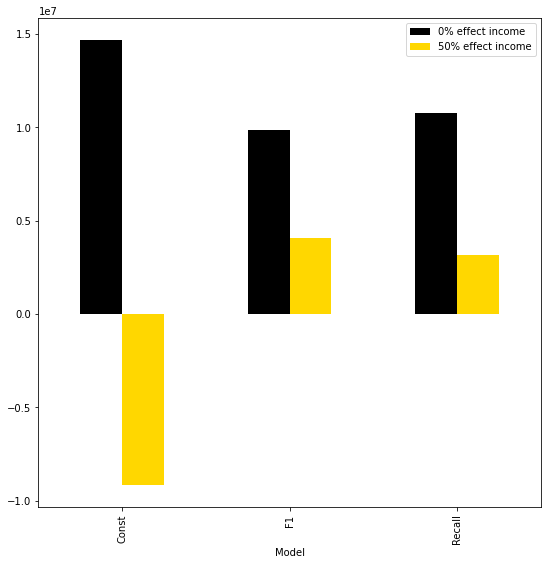

In [165]:
(n_dat_df.pivot_table(index = 'Model').plot(kind = 'bar', figsize = (9,9), color = ['black','gold']))

Модели показывают себя разносторонне, в зависимости от обстоятельств. Предпочтительность модели будет зависеть от реакции клиента на необходимость внесения депозита. 
* Чем реакция клиента негативней(отказ от факта бронирования), тем предпочтительнее модель с большим параметром Precision, что входит в метрику f1: **DecisionTreeClassifier(class_weight='balanced', criterion='entropy', max_depth=7, min_samples_split=10, random_state=0)**


* Чем реакция клиента лояльней(бронирование со внесением депозита), тем меньше модели важен Precision и предпочтительней больший показатель Recall: Подходящая модель - **DecisionTreeClassifier(random_state=0, max_depth= 4, class_weight = 'balanced')**

Т.к. нельзя предполагать полную лояльность клиентов к введению депозита, вероятность 'чистого', цифрового дохода стремится к нулю. 

Однако, даже в условиях 'оттока' 50% клиентов, ввиду негативной реакции на депозит - каждая модель показала позитивный доход и опредлённо превзашла статичную модель.

При отсутствии проведения A/B тестирования, рекомендуется изначально использовать **DecisionTreeClassifier(random_state=0, max_depth= 4, class_weight = 'balanced')**, а при увеличении негативной реакции(оттока) перейти на **DecisionTreeClassifier(class_weight='balanced', criterion='entropy', max_depth=7, min_samples_split=10, random_state=0)**



## Портрет «ненадёжного» клиента

### Физический анализ

In [166]:
df1 = pd.read_csv('/datasets/hotel_train.csv')
df2 = pd.read_csv('/datasets/hotel_test.csv')
stats = pd.concat([df1, df2])

<AxesSubplot:>

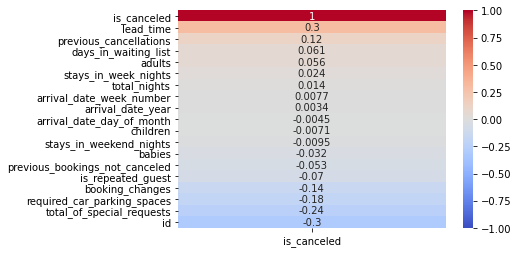

In [167]:
sns.heatmap(stats.corr()[['is_canceled']].sort_values('is_canceled', ascending = False),vmin = -1, vmax = +1,  annot = True, cmap = 'coolwarm')

In [168]:
display(stats[stats['is_canceled'] == 1 ].describe())

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,"36,635.00","36,635.00","36,635.00","36,635.00","36,635.00","36,635.00","36,635.00","36,635.00","36,635.00","36,635.00","36,635.00","36,635.00","36,635.00","36,635.00","36,635.00","36,635.00","36,635.00","36,635.00","36,635.00"
mean,"37,979.73",1.00,132.77,"2,016.15",26.98,15.73,0.83,2.30,1.88,0.07,0.00,0.01,0.21,0.02,0.09,3.50,0.00,0.32,3.13
std,"17,525.11",0.00,99.85,0.72,13.20,8.74,0.85,1.29,0.45,0.34,0.05,0.12,1.24,0.71,0.44,17.23,0.00,0.64,1.64
min,4.00,1.00,0.00,"2,015.00",1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
25%,"31,662.50",1.00,48.00,"2,016.00",17.00,8.00,0.00,1.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00
50%,"41,891.00",1.00,109.00,"2,016.00",26.00,16.00,1.00,2.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.00
75%,"51,065.50",1.00,201.00,"2,017.00",38.00,23.00,2.00,3.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4.00
max,"96,165.00",1.00,374.00,"2,017.00",53.00,31.00,4.00,6.00,4.00,3.00,1.00,1.00,26.00,58.00,16.00,236.00,0.00,5.00,10.00


In [169]:
display(stats[stats['is_canceled'] == 0 ].describe())

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,"61,006.00","61,006.00","61,006.00","61,006.00","61,006.00","61,006.00","61,006.00","61,006.00","61,006.00","61,006.00","61,006.00","61,006.00","61,006.00","61,006.00","61,006.00","61,006.00","61,006.00","61,006.00","61,006.00"
mean,"55,698.31",0.00,75.12,"2,016.14",26.76,15.81,0.85,2.24,1.82,0.08,0.01,0.04,0.02,0.19,0.27,1.60,0.09,0.71,3.08
std,"31,203.30",0.00,81.38,0.70,14.10,8.76,0.85,1.40,0.50,0.34,0.11,0.19,0.29,1.85,0.68,13.83,0.28,0.82,1.80
min,0.00,0.00,0.00,"2,015.00",1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
25%,"21,998.25",0.00,9.00,"2,016.00",15.00,8.00,0.00,1.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00
50%,"67,359.50",0.00,45.00,"2,016.00",27.00,16.00,1.00,2.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,3.00
75%,"82,641.75",0.00,118.00,"2,017.00",39.00,23.00,2.00,3.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,4.00
max,"97,903.00",0.00,373.00,"2,017.00",53.00,31.00,4.00,6.00,4.00,3.00,10.00,1.00,13.00,72.00,18.00,259.00,8.00,5.00,10.00


In [170]:
stats[stats['is_canceled'] == 1]['customer_type'].value_counts(normalize = True)*100 

Transient         81.40
Transient-Party   15.41
Contract           3.10
Group              0.09
Name: customer_type, dtype: float64

In [171]:
stats['customer_type'].value_counts(normalize = True) * 100

Transient         74.72
Transient-Party   21.64
Contract           3.18
Group              0.46
Name: customer_type, dtype: float64

In [172]:
stats[stats['is_canceled'] == 1]['reserved_room_type'].value_counts(normalize = True)*100

A                  79.64
D                  13.66
E                   3.17
F                   1.40
B                   0.94
G                   0.84
C                   0.36
Name: reserved_room_type, dtype: float64

In [173]:
stats['reserved_room_type'].value_counts(normalize = True) * 100

A                  75.76
D                  15.88
E                   4.19
F                   1.76
B                   1.08
G                   0.89
C                   0.44
Name: reserved_room_type, dtype: float64

In [174]:
stats[stats['is_canceled'] == 1]['meal'].value_counts(normalize = True)*100

BB          78.27
SC          10.48
HB           9.84
FB           0.89
SC           0.52
Name: meal, dtype: float64

In [175]:
stats['meal'].value_counts(normalize = True) * 100

BB          78.23
SC          10.56
HB           9.93
SC           0.79
FB           0.50
Name: meal, dtype: float64

In [176]:
stats[stats['is_canceled'] == 1]['country'].value_counts(normalize = True)*100

PRT   61.41
GBR    5.48
FRA    4.73
ESP    4.63
ITA    3.43
       ... 
LIE    0.00
MUS    0.00
ALB    0.00
UMI    0.00
MYT    0.00
Name: country, Length: 125, dtype: float64

In [177]:
stats['country'].value_counts(normalize = True) * 100

PRT   39.65
FRA    9.68
GBR    9.25
ESP    7.00
DEU    6.42
       ... 
CYM    0.00
BDI    0.00
GUY    0.00
MRT    0.00
MYT    0.00
Name: country, Length: 174, dtype: float64

### Анализ данных модели:

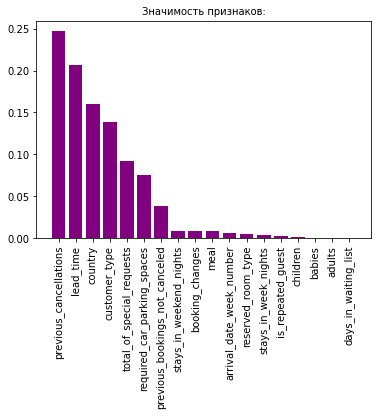

In [179]:
f_t = features_train
encoder = OrdinalEncoder() #1 
data_ordinal = pd.DataFrame(encoder.fit_transform(f_t), 
                                                      columns=f_t.columns)
model = DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=7, min_samples_split=10, random_state=0)
model.fit(data_ordinal, target_train)

importances = pd.DataFrame(data={
    'Attribute': data_ordinal.columns,
    'Importance': model.feature_importances_
})

importances = importances.sort_values(by='Importance', ascending=False)

plt.bar(x=importances['Attribute'], height=importances['Importance'], color='purple')
plt.title('Значимость признаков:', size=10)
plt.xticks(rotation=90)
plt.show()

In [180]:
print(data_ordinal.columns)

Index(['lead_time', 'arrival_date_week_number', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'booking_changes', 'days_in_waiting_list', 'customer_type',
       'required_car_parking_spaces', 'total_of_special_requests'],
      dtype='object')


### Вывод по портрету клиента:

 **Исходя с предоставленных данных, ненедёжные клиенты с большей вероятностью обладает следующими харрактерными особоенностями:**
 * Время оформления заказа такого клиента имеет большой временной разрыв со временем заселения.(на 50 дней дольше, в среднем);
 * За клиентом наблюдаются факты отмены заказов ранее(20%);
 * ~61% вероятность, что клиент отменивший заказ будет из португалии;
 * Клиент не заинтересован в месте для парковки автомобиля;
 * Вносит изменения реже, чем надежный клиент;
 * У клиента меньше подтверждённых ранее заказов;
 * Клиент ставил меньше оценок;

**Особенности отличительно отмеченные моделью (при схожей, но отличной формой кодировки):**

* Количество отменённый ранее заказов - самый важный показатель определяющий будущее поведение.
* Количество дней между датой бронирования и заезда - второй по массе весов признак.
* Значительный вклад вносит место жительства клиента.
* Тип арендованного помещения, количество специальных отметок и место для автомобила - делят последние, серьёзные веса

* Признаки, нашедшие минимальное взаимодействие с поведением клиента: дней ожидания подтверждения заказа, количество постояльцев и наличие младенцев.

**Итого: Признаки обнаруженные моделью выглядят правдоподобно и сходны с теми взаимосвязями, что были найдены естественным образом.**

## Общий вывод

Обработаны значения в данных: исправелены скрытые, категориалные, дубликаты. Удалены аномальные значения. 
Приято решение убрать группу очень больших значений столбца lead_time, который наиболее коррелирует с целевым признаком. 


Целевой признак находится в дисбалансе, составляя около трети всех значений. ~~Следовательно, параллельно с обучением на исходной выборке был применён метод upsamplin, уравнивающий выборку.~~

Выборка для обучения модели была обработана под задачу бинарной классификации: удалены коррелирующие, взаимозаменяемые признаки и столбцы не оказывающие влияние на поведение клиента.


Среди трёх исследуемых моделей:  DecisionTreeClassifier, LogisticRegression, RandomForestClassifier,
при помощи метода кросс-валидации были выбраны модели с наибольшими целевыми точностями по-номерам:
1. *  **model = DecisionTreeClassifier**   ( f1 )
   * гиперпараметры модели: **class_weight='balanced', criterion='entropy', max_depth=7, min_samples_split=10, random_state=0**
2. *  **model = DecisionTreeClassifier** ( Recall )
   * Гиперпараметры: **random_state=0, max_depth= 4, class_weight = 'balanced'**
* Модели удостоверили свои точности на тестовых выборках и прошли сравнение со статичнной моделью.

Задача создания моделей была для определения клиента, отменяющего бронирование, для предложения бронирования только после 80%'го депозита. Модли показали себя позитивно как в идеальных, так и приближеным к 'плохим', условиям.

1. Модель f1 показывает прибыль:
*  в идеальных условиях: 10,232,954
*  в условиях оттока 50% клиентов, к которм применена новая система:  4,453,309


2. Модель Recall показывает прибыль: 
*  в идеальных условиях: 11,150,048
*  в условиях оттока 50% клиентов, к которм применена новая система: 3,565,219

Вторая модель благоприятна к использованию, в случае, лояльного отношения пользователей к депозиту, в то время как первая, лучше справляется в негативных для нововведения условиях.

Физическая оценка 'ненадёжного' клиента показала большую зависимость отмены заказа от длины временного промежутка от заявки, до заселения. Что может быть обусловлено более долгим путём от размышления до целевого действия. Такой клиент уже мог ранее отменять заказы и список его подтверждённых заказов - гораздо меньше, как, соответственно и количество оценок. 

Такая оценка сходится с признаками, которые определила модель для предсказания клиента, склонного к отмене бронирования.

**Дополнительный комментарий**

* При большом потоке клиентов из Португалии(PRT), процент отмены из этой страны превышает 60%, что составляет очень значительную часть массива данных.

* Чистая прибыль рассчитанная моделью требует дополнительного тестирования, ориентировочно: A\B- теста. Введение депозита может отпугнуть потенциально заинтересованных в заселении клиентов и снизить их общий поток. Т.К. предложение внесения депозита не носит 100% точность по True Positive целевого признака. Вероятно, дальнейшее улучшение и разработка модели принесёт ещё большую выгоду и позволит сгладить недочёты.

* По версии модели можно выделить следующий незначимый признак: days_in_waiting_list